In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from curvefit.core.model import CurveModel
from curvefit.core.functions import ln_gaussian_cdf, gaussian_cdf
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from copy import deepcopy
import pdb
import matplotlib as mpl
from IPython.display import display, HTML
from scipy.optimize import rosen, differential_evolution
import warnings
from functools import partial
import tqdm

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-darkgrid')

In [64]:
# Get social distancing data from Google
!wget https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=2dcf78defb92930a

--2020-05-24 18:16:20--  https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=2dcf78defb92930a
Resolving www.gstatic.com (www.gstatic.com)... 172.217.27.163
Connecting to www.gstatic.com (www.gstatic.com)|172.217.27.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22896476 (22M) [text/csv]
Saving to: ‘Global_Mobility_Report.csv?cachebust=2dcf78defb92930a.1’

Global_Mobility_Rep 100%[===================>]  21.83M  1.90MB/s    in 10s     

2020-05-24 18:16:31 (2.12 MB/s) - ‘Global_Mobility_Report.csv?cachebust=2dcf78defb92930a.1’ saved [22896476/22896476]



In [2]:
# Fetches the data from the COVID19India website
class DataFetcher:
    def __init__(self, url="https://api.covid19india.org/data.json"):
        self.url = url
        self.json_data = None
        self.cases_time_series = None
        
    def fetch(self):
        r = requests.get(url=self.url)
        self.json_data = r.json()
        
        # NOTE : start date of this data is 30 Jan
        
        # Get the fields
        fields = list(self.json_data['cases_time_series'][0].keys())
        self.cases_time_series = {}
        
        for field in fields:
            if field == 'date':
                self.cases_time_series[field] = [x[field] for x in self.json_data['cases_time_series']]
            else:
                self.cases_time_series[field] = np.array([float(x[field]) for x in self.json_data['cases_time_series']])

In [3]:
# class GaussianCDF:
#     """Fit a single Gaussian Atom to cumulative daily deaths"""
    
#     def __init__(self, social_distance=None, loss_fun=None):
#         self.model = None
#         self.social_distance = social_distance
#         self.num_params = 3
#         self.predictions = None
#         self.loss_fun = loss_fun
    
#     def fit(self, daily_deaths, fe_init=None):
#         daily_deaths = np.array(daily_deaths)
#         n_data = daily_deaths.shape[0]
        
#         # Prepare the data frame
#         df = pd.DataFrame()
#         df['death_rate'] = np.cumsum(daily_deaths)
#         df['time'] = np.arange(df['death_rate'].shape[0])
#         df['ln_death_rate'] = np.log(df['death_rate'] + 1) # Add 1 to pad in case the #deaths are zero
#         df['group'] = ['all'] * n_data
#         df['cov_one'] = [1.0] * n_data 
        
        
#         if self.social_distance is not None:
#             df['social_distance'] = self.social_distance 
#             col_covs = [['cov_one', 'social_distance']] * 3
#             num_fe = 6
# #             fe_init = [-3, 0, 100, 0, 10, 0] if fe_init is None else fe_init
#         else:
#             col_covs = [['cov_one']] * 3
#             num_fe = 3
# #             fe_init = [-3, 100, 1] if fe_init is None else fe_init
        
#         preds = None
        
#         def print_progress(xk, convergence=0):
#             """Print the progress of the evolution algo"""
            
#             np.set_printoptions(precision=3)
#             print("x0: {} conv: {:.3e}".format(xk, convergence), end="\r")
    
#         # Function which is used to carry out the differential evolution
#         def f(fe_init):
            
#             # Set up the CurveModel
#             self.model = CurveModel(
#                 df=df,
#                 col_t='time',
#                 col_obs='ln_death_rate',
#                 col_group='group',
#                 col_covs=col_covs,
#                 param_names=['alpha', 'beta', 'p'],
#                 link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
#                 var_link_fun=[lambda x: x] * num_fe,
#                 fun=ln_gaussian_cdf,
#                 loss_fun=self.loss_fun
#             )


#             # Fit the model to estimate parameters
#             self.model.fit_params(
#                 fe_init=fe_init,
#                 options={
#                     'ftol': 1e-14,
#                     'maxiter': 500
#                 },
#                 re_bounds= [[0, 0]] * num_fe    # No random effects
#             )
            
#             # Get the mean-squared loss
#             if self.social_distance is None:
#                 self.predictions = self.model.predict(t=df['time'], group_name='all')            
#             else:
#                 self.predictions = self.predict_covar(df['time'])
                
#             loss = np.mean(np.square(df['ln_death_rate'] - self.predictions))
            
#             return loss
        
        
#         if self.social_distance is not None:

#             bounds = [
#                 (-4, -2),  # a
#                 (-0.2, 0.2),   # c_a
#                 (50, 120), # b
#                 (-0.2, 0.2),   # c_b
#                 (5, 15),   # phi
#                 (-0.2, 0.2),   # c_phi 
#             ]
        
#         else:
            
#             bounds = [
#                 (-4, -2),  # a
#                 (50, 120), # b
#                 (5, 15)    # phi
#             ]
        
#         warnings.simplefilter("ignore")
        
#         result = differential_evolution(f, bounds, callback=print_progress)
#         print('\n')
        
#         warnings.simplefilter("default")
        
        
#     def predict(self, t):
#         """Get predictions for values in t"""
        
#         return self.model.predict(t=t, group_name='all')
# #         return self.predictions
    
#     def get_params(self):
#         return np.squeeze(self.model.params)
    
#     def predict_covar(self, t):
#         """Get predictions taking into account social distancing covariates"""
        
#         # Prepare the list of parameters to be fed into the ln_gaussian_cdf function
#         params = self.model.expanded_params
        
#         if len(t) > self.social_distance.shape[0]:
#             # For prediction into the future use the aggregated parameters 
            
#             future_days = len(t) - self.social_distance.shape[0]
            
#             for i in range(future_days):
#                 params = np.append(params, self.model.params, axis=1)
#         else:
#             params = params[:len(t)]
            
#         return ln_gaussian_cdf(t, params)

In [135]:
class GaussianCDF:
    """Fit a single Gaussian Atom to cumulative daily deaths"""
    
    def __init__(self, social_distance=None, loss_fun=None):
        self.model = None
        self.social_distance = social_distance
        self.num_params = 3
        self.predictions = None
        self.loss_fun = loss_fun
    
    def fit(self, daily_deaths, fe_init=None, verbose=False, time_values=None, **fit_kwargs):
        daily_deaths = np.array(daily_deaths)
        n_data = daily_deaths.shape[0]
        
        # Prepare the data frame
        df = pd.DataFrame()
        df['death_rate'] = np.cumsum(daily_deaths)
        
        if time_values is None:
            df['time'] = np.arange(df['death_rate'].shape[0])
        else:
            df['time'] = time_values 
            
        df['ln_death_rate'] = np.log(df['death_rate'] + 1) # Add 1 to pad in case the #deaths are zero
        df['group'] = ['all'] * n_data
        df['cov_one'] = [1.0] * n_data 
        
        
        if self.social_distance is not None:
            df['social_distance'] = self.social_distance 
            col_covs = [['cov_one', 'social_distance']] * 3
            num_fe = 6
            fe_init = [-3, 0, 100, 0, 10, 0] if fe_init is None else fe_init
            fe_bounds = [[-4, -2], [-1, 1], [50, 150], [-1, 1], [8, 13], [-1, 1]]
        else:
            col_covs = [['cov_one']] * 3
            num_fe = 3
            fe_init = [-3, 100, 1] if fe_init is None else fe_init
            fe_bounds = [[-5, -1], [30, 150], [5, 13]]
            
        # Set up the CurveModel
        self.model = CurveModel(
            df=df,
            col_t='time',
            col_obs='ln_death_rate',
            col_group='group',
            col_covs=col_covs,
            param_names=['alpha', 'beta', 'p'],
            link_fun=[lambda x: np.exp(x), lambda x: x, lambda x: np.exp(x)],
            var_link_fun=[lambda x: x] * num_fe,
            fun=ln_gaussian_cdf,
            loss_fun=self.loss_fun,
        )
        
        # Fit the model to estimate parameters
        self.model.fit_params(
            fe_init=fe_init,
            options={
                'ftol': 1e-14,
                'maxiter': 500
            },
            re_bounds= [[0, 0]] * num_fe,    # No random effects
            fe_bounds=fe_bounds,
            popsize=50,
            verbose=verbose,
            **fit_kwargs
        )
        
    def predict(self, t):
        """Get predictions for values in t"""
        
        return self.model.predict(t=t, group_name='all')
#         return self.predictions
    
    def get_params(self):
        return np.squeeze(self.model.params)
    
    def predict_covar(self, t, sampled_indices=None):
        """Get predictions taking into account social distancing covariates"""
        
        # Prepare the list of parameters to be fed into the ln_gaussian_cdf function
        if sampled_indices is not None:
#             params = np.repeat(self.model.params, t.shape[0], axis=1)
#             params[:, sample_indices] = self.model.expanded_params
            num_params = self.model.expanded_params.shape[0]
            params = np.zeros((num_params, t.shape[0]))
        
            # Since some parameter values are missing, interpolate the existing values to get them
            for i in range(num_params):
                params[i] = np.interp(t, sampled_indices, self.model.expanded_params[i])
#                 plt.plot(params[i], label=str(i))
#             plt.legend()
#             plt.show()
        else: 
            params = self.model.expanded_params
        
        if len(t) > params.shape[1]:
            # For prediction into the future use the aggregated parameters 
            
            future_days = len(t) - params.shape[1]
            
            for i in range(future_days):
                params = np.append(params, self.model.params, axis=1)
        else:
            params = params[:len(t)]
            
        return ln_gaussian_cdf(t, params)

In [107]:
def smoothen(X, std):
    result = np.zeros_like(X)
    
    for i, _ in enumerate(X):
        norm_factor = 0
        for j, _X in enumerate(X):
            val = norm.pdf(j, loc=i, scale=std)
            result[i] += _X * val
            norm_factor += val
        result[i] /= norm_factor
    
    return result

In [108]:
def attentive_loss(r, attention=15):
    factors = norm.pdf(np.arange(r.shape[0]), loc=r.shape[0] - 1, scale=attention)
    
    return np.sum(np.square(r) * factors) / np.sum(factors)

In [137]:
def bootstrapped_variance(daily_deaths, social_distance, attention=15, num_samples=30, frac=0.7, plot=False, **fit_kwargs):
    sample_size = int(frac * daily_deaths.shape[0])
    variance = np.zeros_like(daily_deaths)
    mean = np.zeros_like(daily_deaths)
    time_values = np.arange(daily_deaths.shape[0])
    
#     plt.plot(daily_deaths, '.')
    
    print("Sample size {}".format(sample_size))
    
    for _ in range(num_samples):
        sampled_times = np.sort(np.random.choice(time_values, size=sample_size, replace=False))
        sampled_times = np.array(sampled_times, dtype=int)
        sampled_deaths = daily_deaths[sampled_times]
        sampled_social_distance = social_distance[sampled_times]
        
        warnings.filterwarnings("ignore")
        model = GaussianCDF(loss_fun=partial(attentive_loss, attention=attention), 
                            social_distance=sampled_social_distance)
        model.fit(sampled_deaths, time_values=sampled_times, **fit_kwargs)
        warnings.filterwarnings("default")
        
        preds = np.exp(model.predict_covar(t=time_values, sampled_indices=sampled_times))
        preds[1:] = np.diff(preds)
        
        mean += preds
        variance += np.square(preds - daily_deaths)
        
        if plot:
            plt.plot(time_values, preds)
            plt.plot(time_values, daily_deaths, '.')
            
    if plot:
        plt.show()
        
    return np.sqrt(variance / num_samples), mean / num_samples

In [26]:
class DataFetcherState:
    """Fetch data for all states"""
    
    def __init__(self):
        self.data = None
        self.raw_data = None
    
    def fetch(self):
        # Fetch the raw data
        r = requests.get(url="https://api.covid19india.org/states_daily.json")
        self.raw_data = r.json()
        self.data = {}
        
        # Iterate over the days and record the data
        for entry in self.raw_data['states_daily']:
            status = entry['status'].lower()
            for state in entry:
                if state == "date" or state == "status":
                    continue
                    
                if state not in self.data:
                    # Initialize this state
                    self.data[state] = {
                        'deceased': [],
                        'recovered': [],
                        'confirmed': []
                    }
                
                # Append the data
                self.data[state][status].append(entry[state])
                
    def start_date(self):
        return self.raw_data['states_daily'][0]['date']

<h2>Fitting a model for cumulative number of deaths in India</h2>

Description - the model is a generalized fixed effects model. Since there is only one location (for now) the link functions are simple and random effects are neglected. Further, social distancing covariates are ignored as a first approximation. 

$$f(t; \alpha, \beta, p) =
        \frac{p}{2} \left( 1 + \frac{2}{\pi} \int_0^{\alpha ( t - \beta )}
            \exp( - \tau^2 ) d \tau \right)$$
            
Here, $f$ is the cumulative number of deaths and $\alpha, \beta, p$ are parameters with the following link functions

\begin{aligned}
    \alpha & = \exp( a ) \\
    \beta  & =  b \\
    p      & = \exp( \phi  )
\end{aligned}

where $a, b, \phi$ are fixed effects learnt by the model. This amounts to fitting a Gaussian on the daily death data.

<h3>Single Gaussian Atom</h3>

In [62]:
fetcher = DataFetcher()
fetcher.fetch()

--2020-05-24 18:15:49--  https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv?cachebust=2dcf78defb92930a
Resolving www.gstatic.com (www.gstatic.com)... 172.217.27.163
Connecting to www.gstatic.com (www.gstatic.com)|172.217.27.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22896476 (22M) [text/csv]
Saving to: ‘Global_Mobility_Report.csv?cachebust=2dcf78defb92930a’

Global_Mobility_Rep 100%[===================>]  21.83M  2.00MB/s    in 10s     

2020-05-24 18:16:00 (2.16 MB/s) - ‘Global_Mobility_Report.csv?cachebust=2dcf78defb92930a’ saved [22896476/22896476]



/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


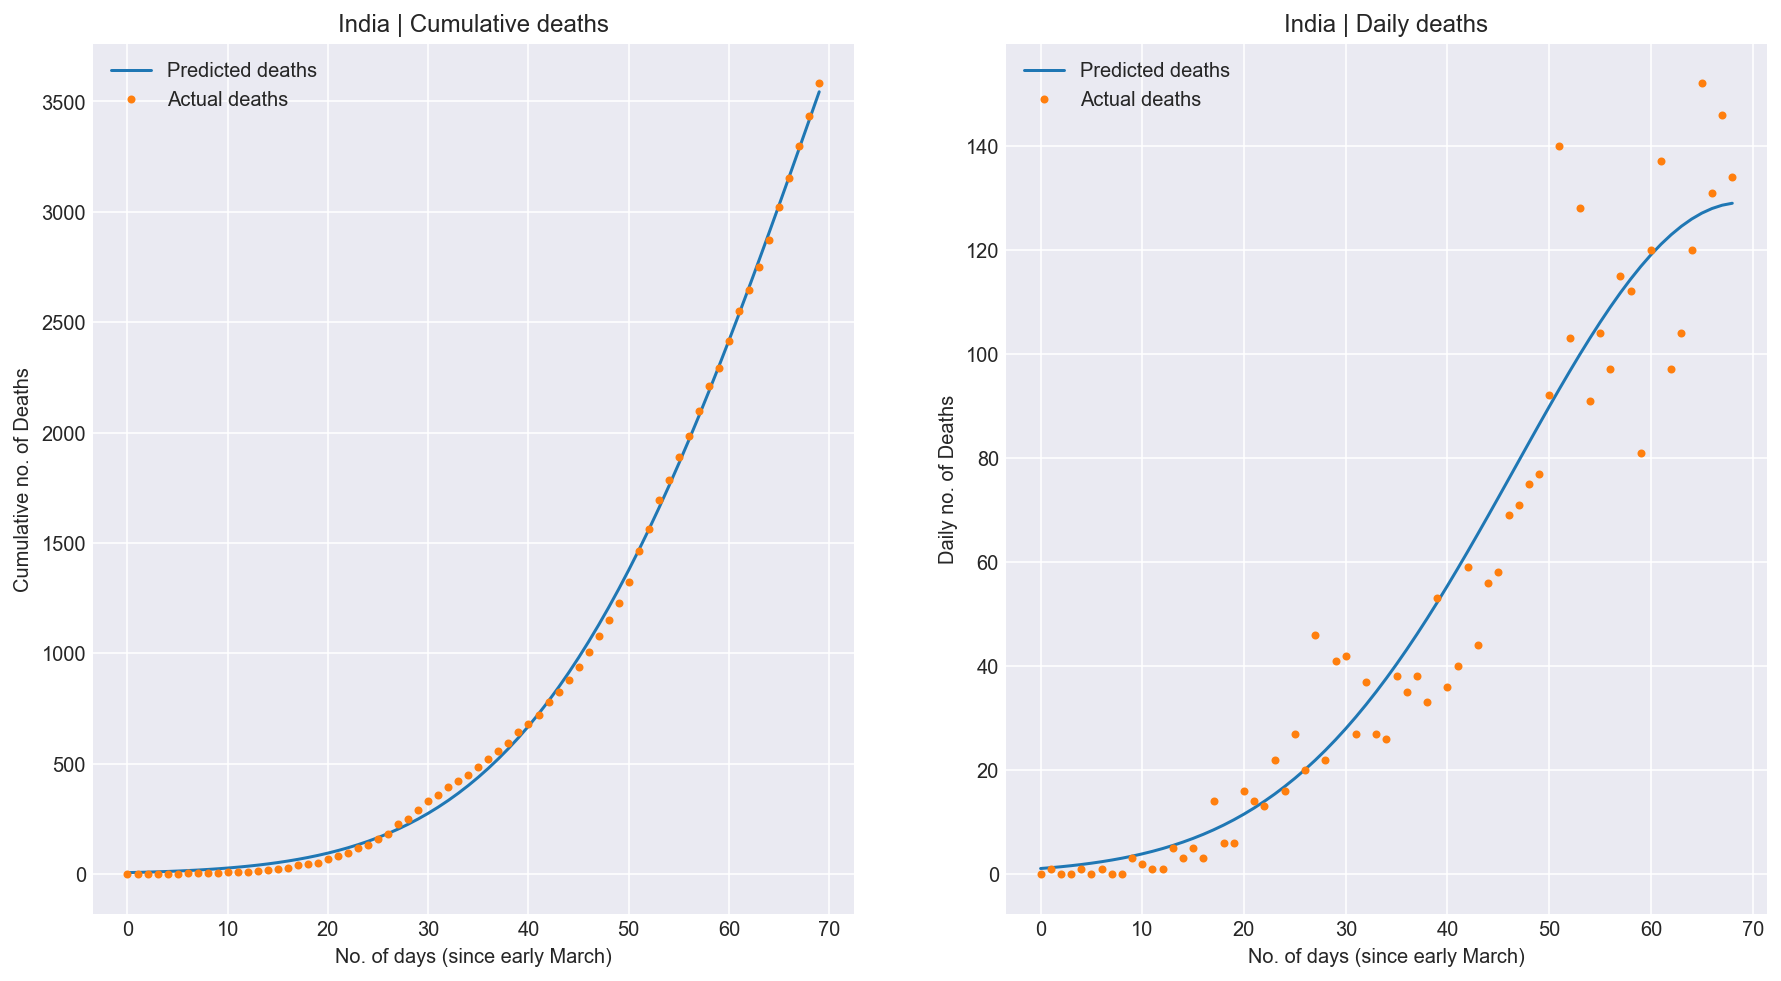

In [22]:
# Fit and plot data
offset = 43 # Start reading data from 14th March
death_data = fetcher.cases_time_series['dailydeceased'][offset:]
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF(loss_fun=attentive_loss)
model_india.fit(death_data)
ln_pred = model_india.predict(time_values)
pred = np.exp(ln_pred)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].plot(time_values, pred, label="Predicted deaths")
axs[0].plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
axs[0].set_title("India | Cumulative deaths")
axs[0].set_xlabel("No. of days (since early March)")
axs[0].set_ylabel("Cumulative no. of Deaths")
axs[0].legend()

axs[1].plot(time_values[:-1], np.diff(pred), label="Predicted deaths")
axs[1].plot(time_values[:-1], death_data[:-1], '.', label="Actual deaths")
axs[1].set_title("India | Daily deaths")
axs[1].set_xlabel("No. of days (since early March)")
axs[1].set_ylabel("Daily no. of Deaths")
axs[1].legend()

fig.show()

<h2>Fitting a model for cumulative number of deaths in MH</h2>

<h2>Single Gaussian Atom</h2>

In [24]:
fetcher = DataFetcherState()
fetcher.fetch()

/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:1154: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5
/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


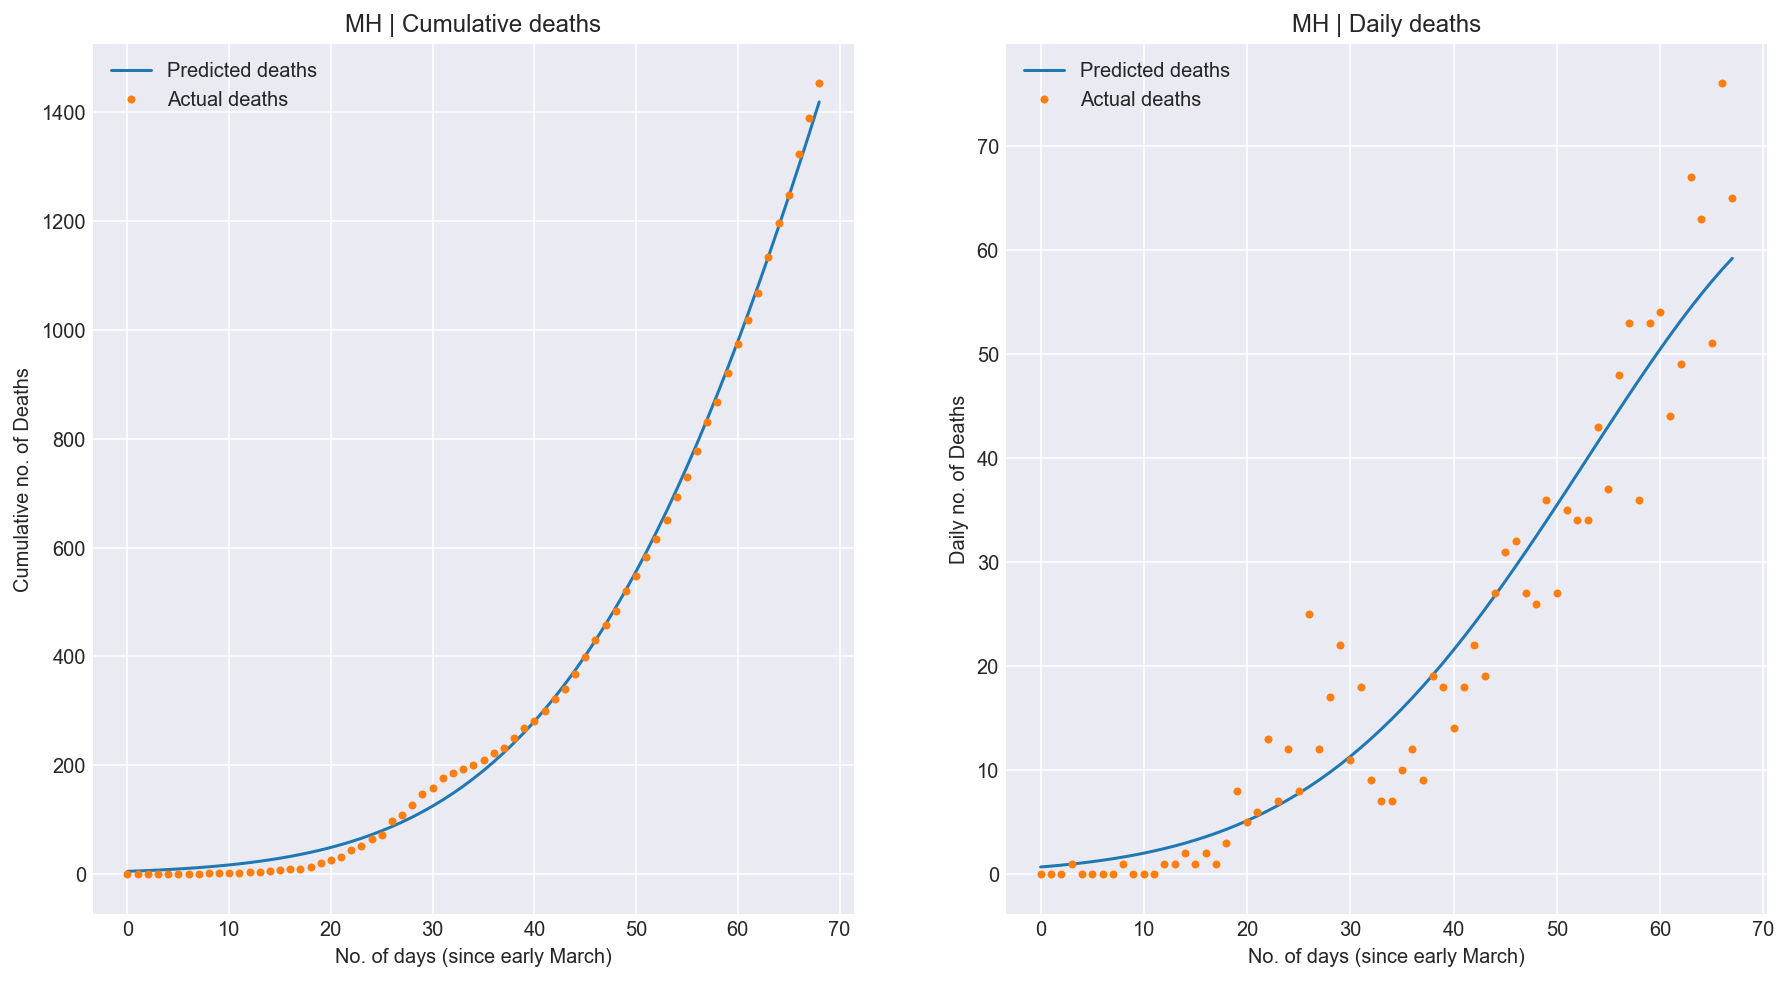

In [27]:
# Fit and plot data
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
time_values = np.arange(death_data.shape[0])

model_mh = GaussianCDF(loss_fun=attentive_loss)
model_mh.fit(death_data)
ln_pred = model_mh.predict(time_values)
pred = np.exp(ln_pred)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

axs[0].plot(time_values, pred, label="Predicted deaths")
axs[0].plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
axs[0].set_title("MH | Cumulative deaths")
axs[0].set_xlabel("No. of days (since early March)")
axs[0].set_ylabel("Cumulative no. of Deaths")
axs[0].legend()

axs[1].plot(time_values[:-1], np.diff(pred), label="Predicted deaths")
axs[1].plot(time_values[:-1], death_data[:-1], '.', label="Actual deaths")
axs[1].set_title("MH | Daily deaths")
axs[1].set_xlabel("No. of days (since early March)")
axs[1].set_ylabel("Daily no. of Deaths")
axs[1].legend()

fig.show()

<h1>Testing predictive power</h1>

Here the model is fit on a subset of the death data. This will then be used extrapolate deaths. The extrapolated deaths can be compared with the actual number of deaths to determine how well the model can predict values. 

<h2>India - single gaussian atom</h2>

In [47]:
fetcher = DataFetcher()
fetcher.fetch()

x0: [-3.48  72.632  8.889  0.     0.     0.   ] conv: 1.005e+0072e-03
x0: [-3.394 67.185  8.655  0.     0.     0.   ] conv: 1.783e+0051e-03
x0: [-3.191 55.518  8.071  0.     0.     0.   ] conv: 3.520e+00
x0: [-3.    46.27   7.513  0.     0.     0.   ] conv: 1.305e+00
x0: [-2.952 43.878  7.337  0.     0.     0.   ] conv: 1.312e+00
x0: [-3.071 51.347  7.969  0.     0.     0.   ] conv: 2.217e+00


/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


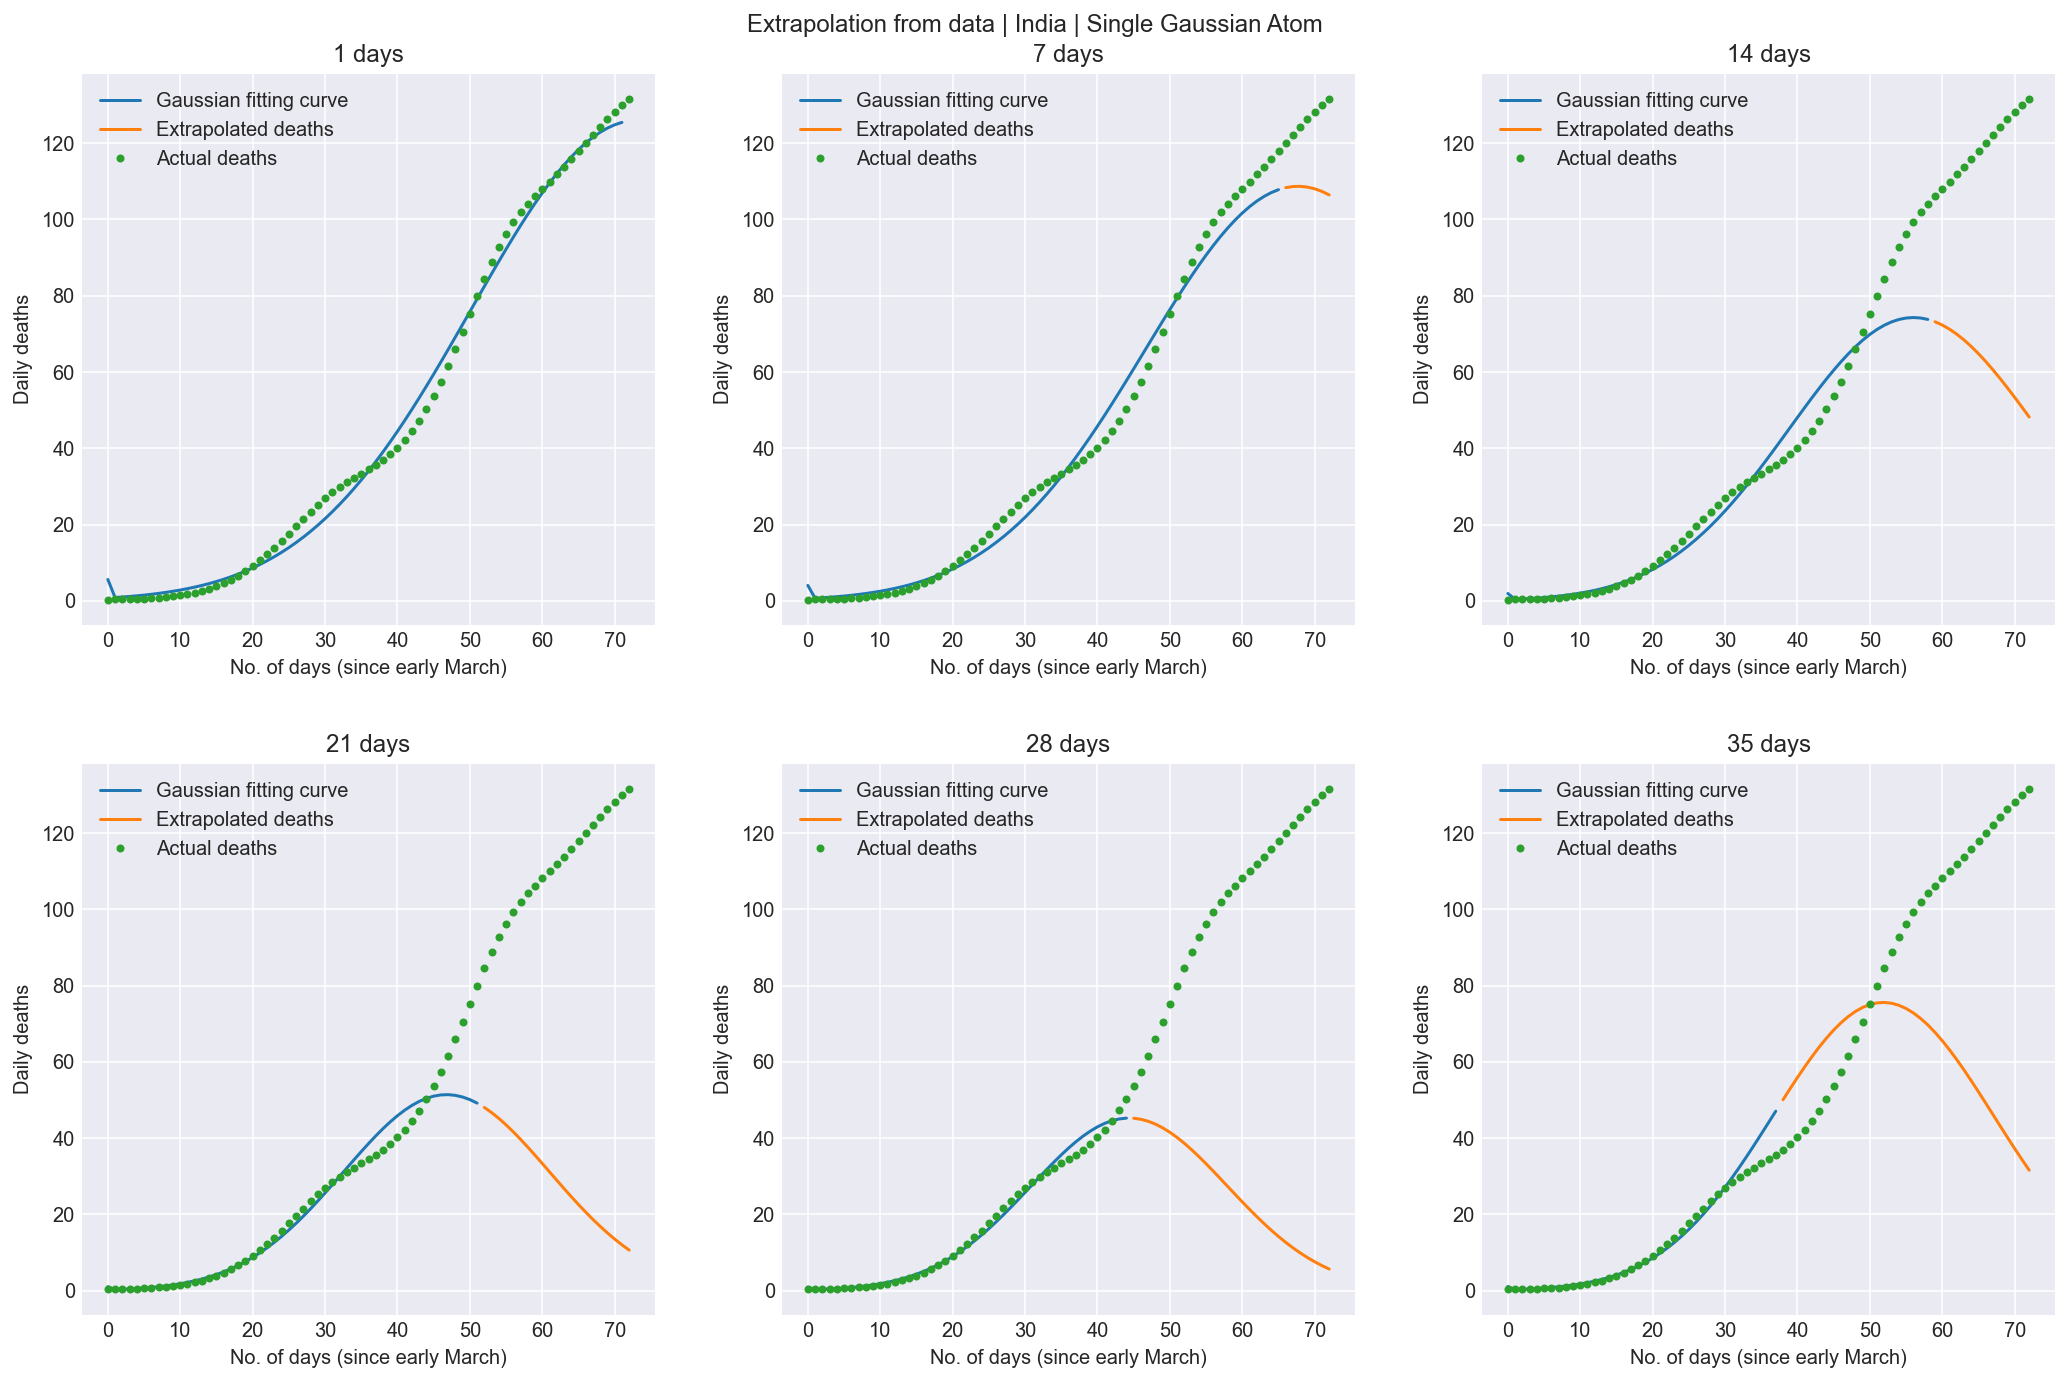

In [48]:
# Plot data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

for limit, ax in zip([1, 7, 14, 21, 28, 35], axs.flat):
    death_data = smoothen(fetcher.cases_time_series['dailydeceased'][offset:], 5)
    time_values = np.arange(death_data.shape[0])

    warnings.filterwarnings("ignore")
    model_india = GaussianCDF(loss_fun=partial(attentive_loss, attention=15))
    model_india.fit(death_data[:-limit], verbose=True)
    pred = model_india.predict(time_values)
    warnings.filterwarnings("default")
    print("")
    
    ax.plot(time_values[:-limit], np.diff(np.exp(pred)[:-limit], prepend=0), label="Gaussian fitting curve")
    ax.plot(time_values[-limit:], np.diff(np.exp(pred)[-limit-1:]), label="Extrapolated deaths")
    ax.plot(time_values, death_data, '.', label="Actual deaths")
    ax.set_title("{} days".format(limit))
    ax.set_xlabel("No. of days (since early March)")
    ax.set_ylabel("Daily deaths")
    ax.legend()
    
fig.suptitle("Extrapolation from data | India | Single Gaussian Atom")
fig.tight_layout(pad=3.0)
fig.show()

<h2>MH - single gaussian atom</h2>

In [50]:
fetcher = DataFetcherState()
fetcher.fetch()

x0: [-3.614 78.044  8.306  0.     0.     0.   ] conv: 1.172e+0071e-03
x0: [-3.389 61.895  7.631  0.     0.     0.   ] conv: 1.074e+0012e-03
x0: [-3.079 46.31   6.854  0.     0.     0.   ] conv: 1.014e+0046e-03
x0: [-2.869 38.187  6.351  0.     0.     0.   ] conv: 1.605e+00
x0: [-2.829 36.548  6.222  0.     0.     0.   ] conv: 1.184e+0035e-03
x0: [-3.038 48.51   7.306  0.     0.     0.   ] conv: 1.806e+00


/Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


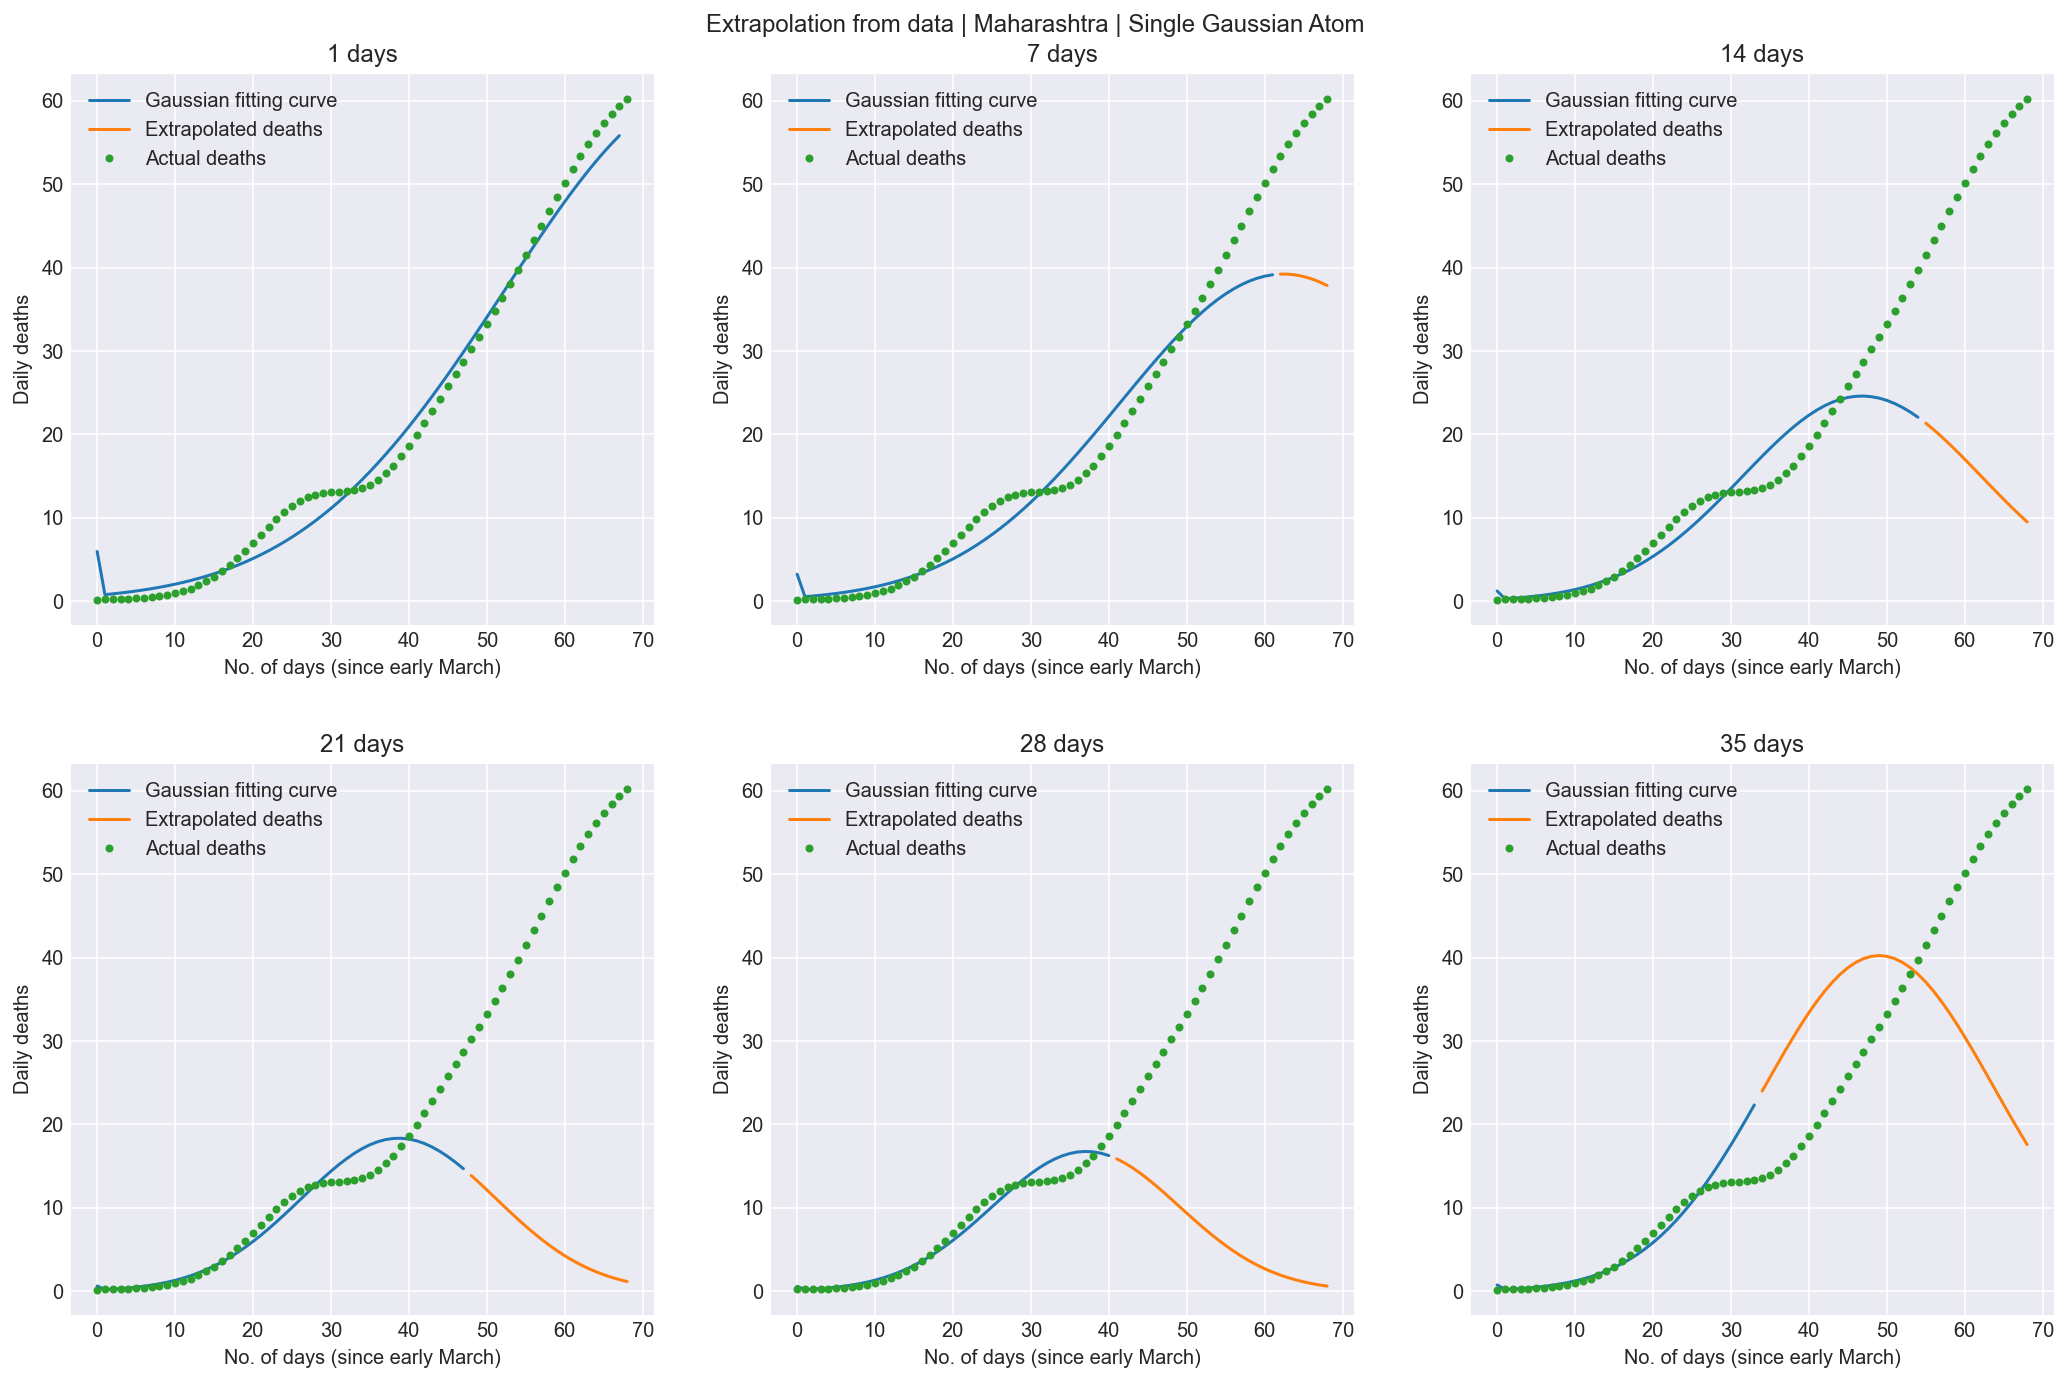

In [53]:
# Plot data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for limit, ax in zip([1, 7, 14, 21, 28, 35], axs.flat):
    death_data = smoothen(np.array(fetcher.data['mh']['deceased'], dtype=float), 5)
    time_values = np.arange(death_data.shape[0])

    warnings.filterwarnings("ignore")
    model_india = GaussianCDF(loss_fun=partial(attentive_loss, attention=15))
    model_india.fit(death_data[:-limit], verbose=True)
    pred = model_india.predict(time_values)
    warnings.filterwarnings("default")
    print("")
    
    ax.plot(time_values[:-limit], np.diff(np.exp(pred)[:-limit], prepend=0), label="Gaussian fitting curve")
    ax.plot(time_values[-limit:], np.diff(np.exp(pred)[-limit-1:]), label="Extrapolated deaths")
    ax.plot(time_values, death_data, '.', label="Actual deaths")
    ax.set_title("{} days".format(limit))
    ax.set_xlabel("No. of days (since early March)")
    ax.set_ylabel("Daily deaths")
    ax.legend()
    
fig.suptitle("Extrapolation from data | Maharashtra | Single Gaussian Atom")
fig.tight_layout(pad=3.0)
fig.show()

<h1>Peak prediction</h1>

<h2>India - single gaussian atom</h2>

In [ ]:
fetcher = DataFetcher()
fetcher.fetch()

In [ ]:
offset = 43 # Exclude data from the starting
extra_pred = 60 # How much to predict into the future

In [ ]:
# Fit and plot data
death_data = fetcher.cases_time_series['dailydeceased'][offset:]
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF(loss_fun=attentive_loss)
model_india.fit(death_data)
future_time_values = np.arange(death_data.shape[0] + extra_pred)
pred = model_india.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | India | Single Gaussian")
plt.show()

<h2>MH - single gaussian atom</h2>

In [ ]:
fetcher = DataFetcherState()
fetcher.fetch()

In [ ]:
extra_pred = 60 # How much to predict into the future

In [ ]:
# Fit and plot data
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)
time_values = np.arange(death_data.shape[0])

model_india = GaussianCDF(loss_fun=attentive_loss)
model_india.fit(death_data)
future_time_values = np.arange(death_data.shape[0] + extra_pred)
pred = model_india.predict(future_time_values)

plt.plot(future_time_values, np.exp(pred), label="Predicted deaths")
plt.plot(time_values, np.cumsum(death_data), '.', label="Actual deaths")
plt.xlabel("No. of days (since early March)")
plt.ylabel("Cumulative deaths")
plt.legend()
plt.title("Predicting future deaths | MH | Single Gaussian")
plt.show()

<h1>Incorporating social distancing data</h1>



We still fit a Gaussian. However, we include a social distancing covariate for $\beta$

$$f(t; \alpha, \beta, p) =
        \frac{p}{2} \left( 1 + \frac{2}{\pi} \int_0^{\alpha ( t - \beta )}
            \exp( - \tau^2 ) d \tau \right)$$
            
Here, $f$ is the cumulative number of deaths and $\alpha, \beta, p$ are parameters with the following link functions

\begin{aligned}
    \alpha & = \exp( a + c_a \cdot s ) \\
    \beta  & =  b + c_b \cdot s \\
    p      & = \exp( \phi + c_\phi\cdot s )
\end{aligned}

where $a, b, \phi, c_a, c_b, c_\phi$ are fixed effects learnt by the model. $s$ is a social distancing covariate derived from Google's mobility data available publicly. The coefficients are chosen to be $1$ for now, but can be modified.

$$s = \Delta I_{r} + \Delta I_{g} + \Delta I_{p} + \Delta I_{t} + \Delta I_{w}$$

where each term corresponds to the percent change in mobility from baselines at different locations. These locations are

* $\Delta I_{r}$ - retail and recreation
* $\Delta I_{g}$ - grocery and pharmacy
* $\Delta I_{p}$ - parks 
* $\Delta I_{t}$ - transit stations
* $\Delta I_{w}$ - workplaces

In [9]:
def get_social_distance(df, death_data):
    """Retrieve social distancing data from dataframe and resize"""

    df = deepcopy(df)
    
#     pdb.set_trace()
    
    # Make the lengths of the data equal
    if len(df) > len(death_data):
        df = df[:-(len(df) - len(death_data))]
    else:
        for i in range(len(death_data) - len(df)):
            df = df.append(df.iloc[-1])

    social_distance = np.zeros(len(df))
    for loc in locations:
        social_distance += np.array(df['{}_percent_change_from_baseline'.format(loc)])
    
    return smoothen(social_distance, 6)

<h3>India</h3>

In [78]:
# Get dataframe for the entire country from 25th Feb
# Although the death data starts from 14 March, we use mobilities from 25th Feb
# This is because the mean time to death is 18 days and so we shift the mobility data forward by 18 days 
df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df = df[df['country_region'] == 'India']
df = df[pd.isnull(df['sub_region_1'])]
df = df[df['date'] >= '2020-02-25']
df.keys()

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

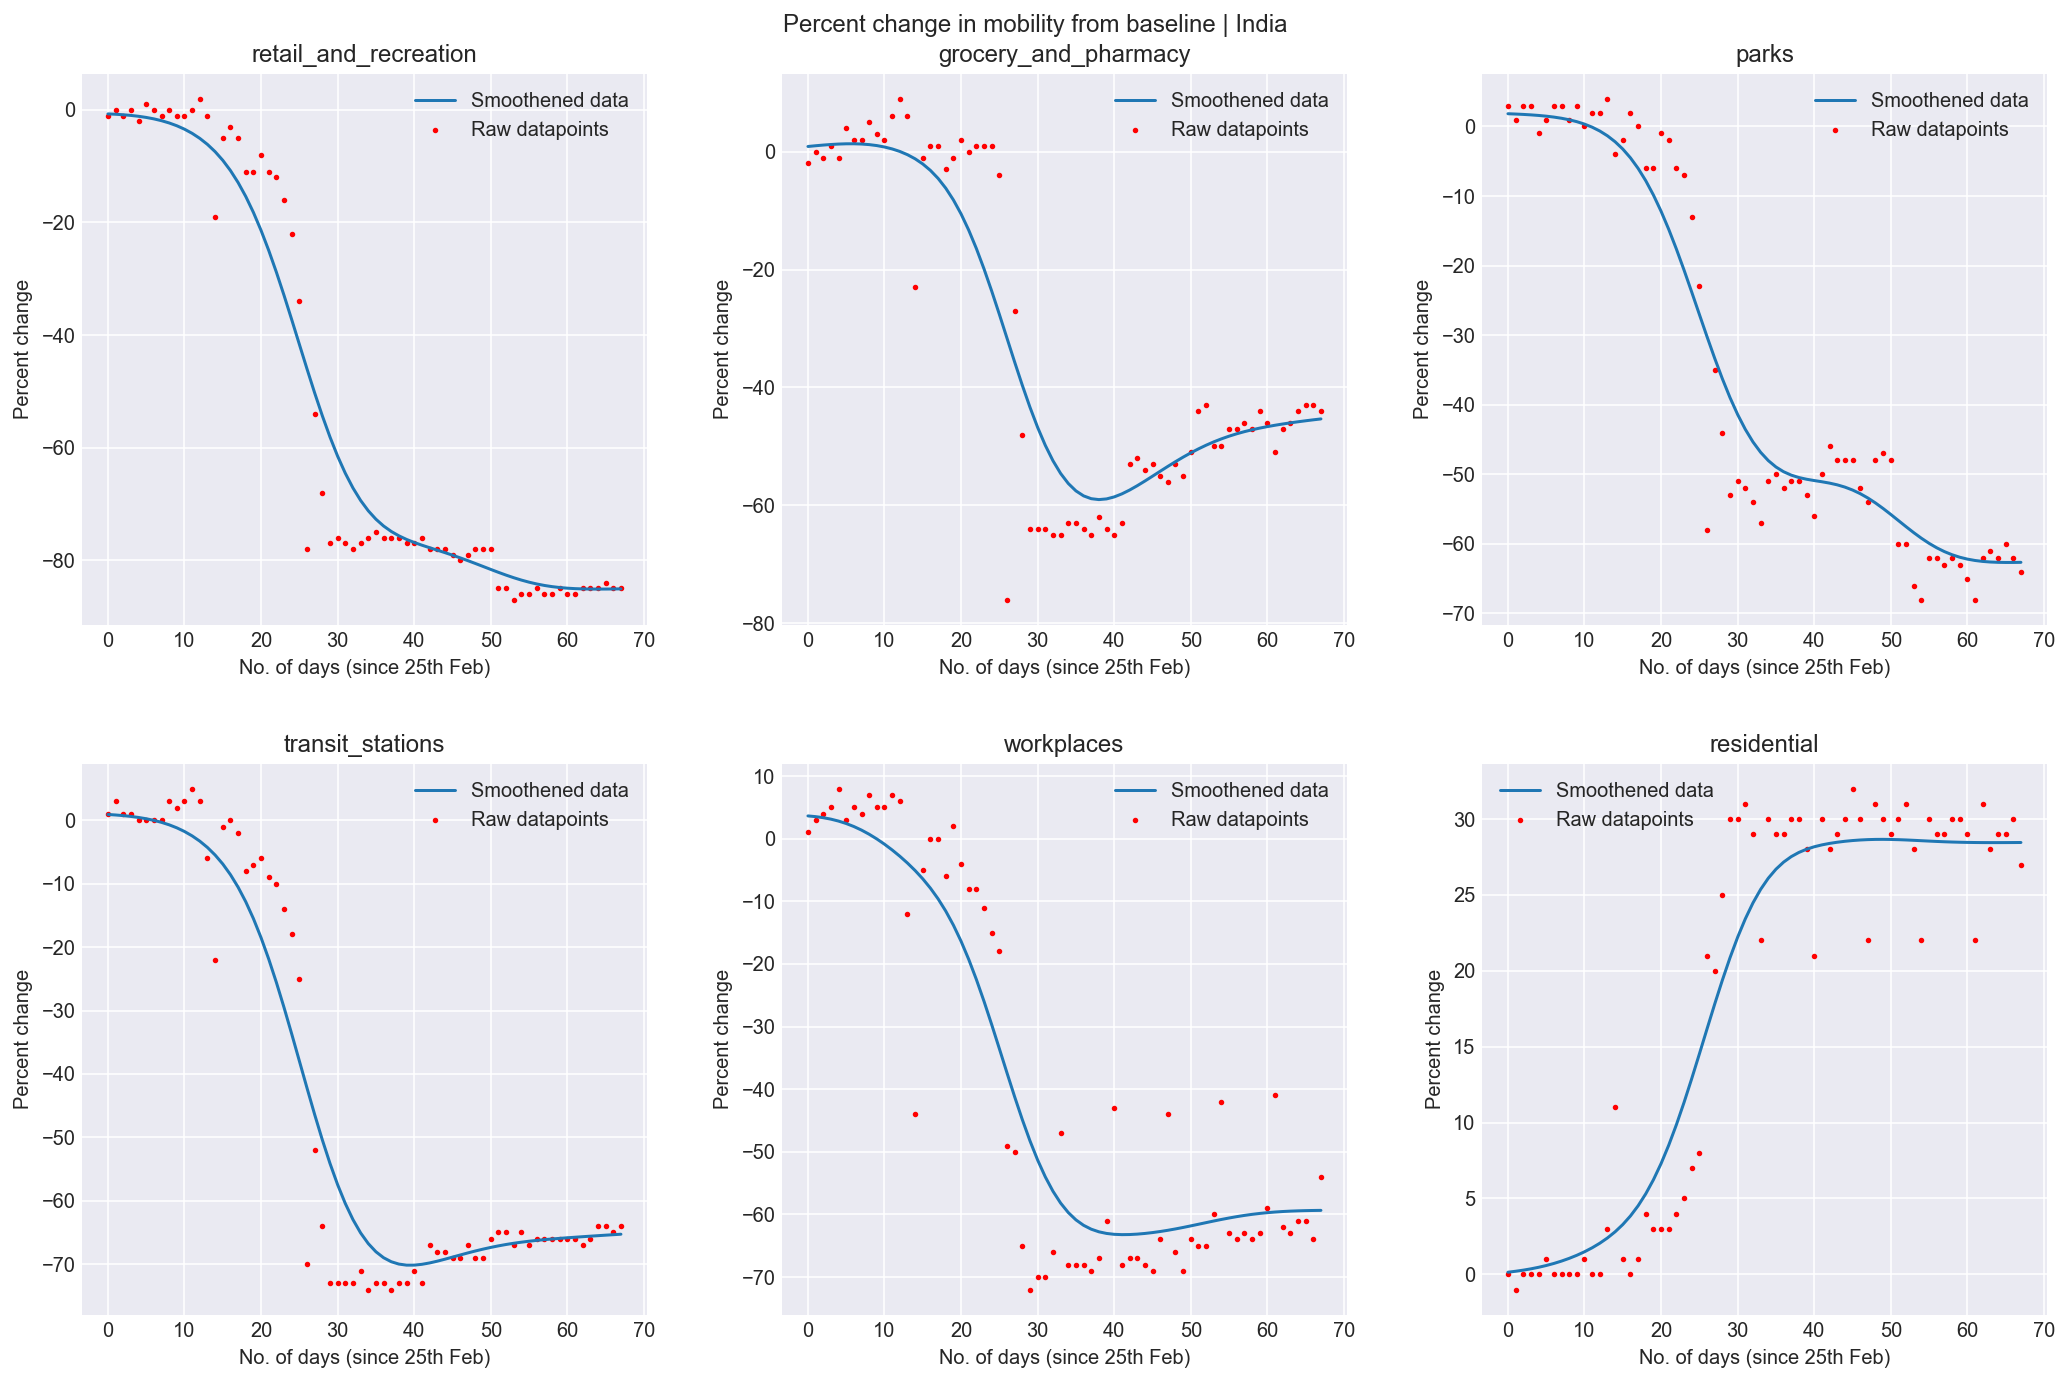

In [79]:
# Plot the data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

locations = ['retail_and_recreation',
             'grocery_and_pharmacy',
             'parks',
             'transit_stations',
             'workplaces',
             'residential']

for loc, ax in zip(locations, axs.flat):
    ydata = np.array(df['{}_percent_change_from_baseline'.format(loc)])
    xdata = range(len(ydata))
    ax.plot(xdata, smoothen(ydata, 6), label="Smoothened data")
    ax.scatter(xdata, ydata, label="Raw datapoints", s=3, c='red')
    ax.set_title("{}".format(loc))
    ax.set_xlabel("No. of days (since 25th Feb)")
    ax.set_ylabel("Percent change")
    ax.legend()
    
fig.suptitle("Percent change in mobility from baseline | India")
fig.tight_layout(pad=3.0)

In [12]:
# Fit and plot data
fetcher = DataFetcher()
fetcher.fetch()

# Exclude these days many days from the starting of the cases time series
offset = 43
death_data = fetcher.cases_time_series['dailydeceased'][offset:]

,attention,days,alpha,beta,gamma,a,c_a,b,c_b,phi,c_phi
0,40,0,0.025674,83.779053,12395.473574,-3.481599,0.000628,96.116210,0.042904,11.409528,0.006901
0,40,3,0.023021,95.350167,19245.011867,-3.497860,0.000942,98.707585,0.011568,11.609919,0.006012
0,40,7,0.018670,127.384095,65015.261397,-3.570429,0.001404,113.651728,-0.046981,12.986950,0.006516
0,40,14,0.018797,127.067930,66507.960797,-3.573914,0.001385,114.070347,-0.044974,12.997235,0.006547
0,40,21,0.017972,130.941622,65672.836450,-3.571499,0.001554,113.116276,-0.061891,12.875295,0.006190
0,40,28,0.018234,128.607177,61181.164079,-3.575935,0.001444,113.757508,-0.050027,12.905275,0.006346


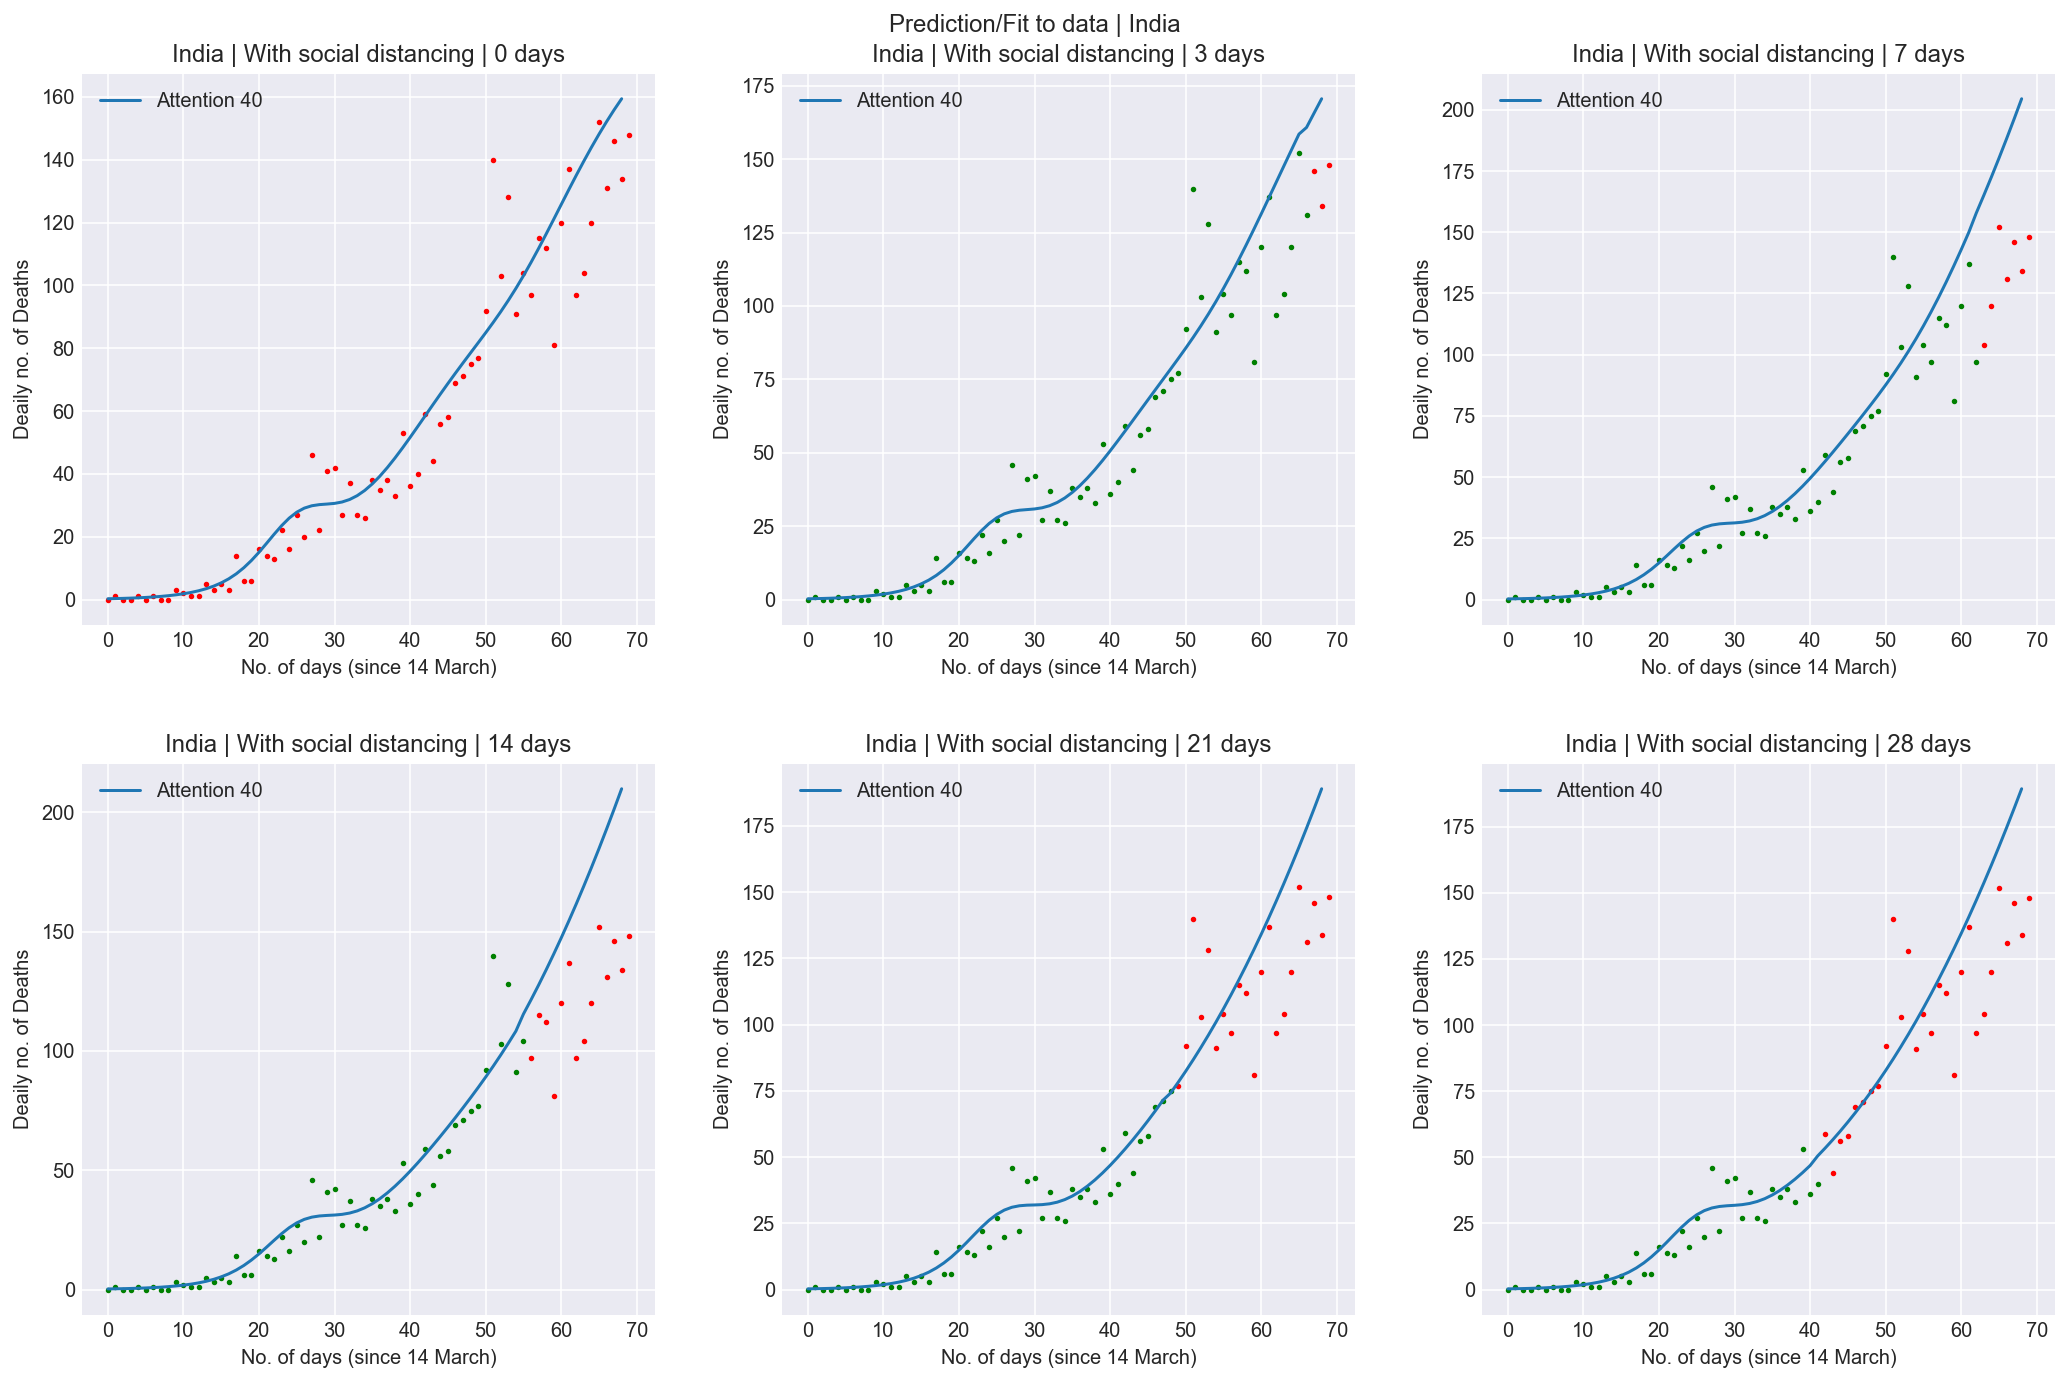

In [16]:
# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
param_table = pd.DataFrame()
future_days = [0, 3, 7, 14, 21, 28]

for fut, ax in zip(future_days, axs.flat):
    s_death_data = death_data[:-fut] if fut != 0 else death_data
    social_distance = get_social_distance(df, s_death_data)
    
    for attention in [40]:
        # Fit and plot data
        np.random.seed(seed=123)

        warnings.filterwarnings("ignore")
        model_india = GaussianCDF(social_distance, loss_fun=partial(attentive_loss, attention=attention))
        model_india.fit(s_death_data, fe_init=[-3, 0.00, 100, 0, 10.0, 0], verbose=True)
        warnings.filterwarnings("default")
#         print("")

        params = model_india.get_params()
        new_row = pd.DataFrame({
            "attention": attention,
            "days"     : [fut],
            "alpha"    : [params[0]],
            "beta"     : [params[1]],
            "gamma"    : [params[2]],
            "a"        : [model_india.model.result.x[0]],
            "c_a"      : [model_india.model.result.x[1]],
            "b"        : [model_india.model.result.x[2]],
            "c_b"      : [model_india.model.result.x[3]],
            "phi"      : [model_india.model.result.x[4]],
            "c_phi"    : [model_india.model.result.x[5]]
        })
        param_table = param_table.append(new_row)

        time_values = np.arange(social_distance.shape[0] + fut)
        pred = model_india.predict_covar(time_values)

        ax.plot(time_values[:-1], np.diff(np.exp(pred)), label="Attention {}".format(attention))
        
        
    ax.set_title("India | With social distancing | {} days".format(fut))
    ax.set_xlabel("No. of days (since 14 March)")
    ax.set_ylabel("Deaily no. of Deaths")
    ax.scatter(time_values[:-fut], death_data[:-fut], s=3, c='green')
    ax.scatter(time_values[-fut:], death_data[-fut:], s=3, c='red')
    ax.legend()

display(param_table)
    
fig.suptitle("Prediction/Fit to data | India")
fig.tight_layout(pad=3.0)

Sample size 64


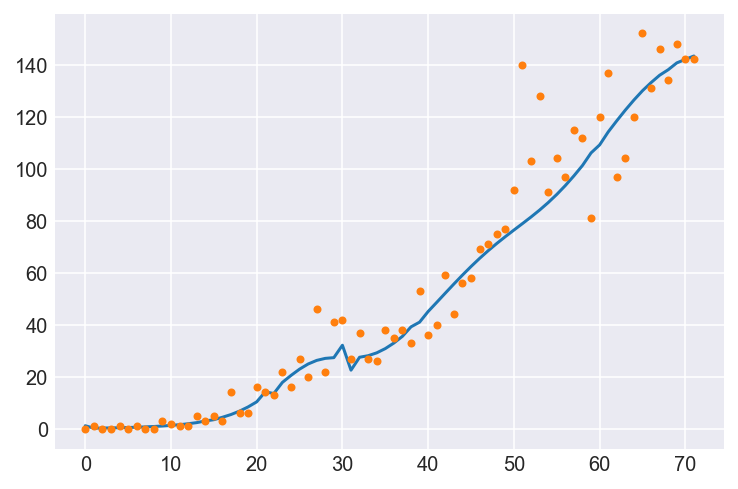

In [142]:
# Get the mean and variance of the data
social_distance = get_social_distance(df, death_data)
variance, mean = bootstrapped_variance(death_data, 
                                       social_distance, 
                                       frac        = 0.9, 
                                       attention   = 40, 
                                       num_samples = 1, 
                                       evolution   = True, 
                                       verbose     = True, 
                                       plot        = True)

In [50]:
variance

array([ 383.33775424,  281.3775092 ,  239.53971508,  197.60670227,
        317.77345168,  319.92449047,  274.24581468,  280.93788197,
        327.31507792,  333.47094878,  185.20479551, 1147.45127786,
       1155.00962435,  263.00892419,  283.62565224,  203.10654875,
       1672.81576601, 1504.24920385, 1478.65654073,  910.02246714,
        328.716763  , 1252.83456503,  994.8589355 ,  967.28162511,
        753.545611  ,  598.31532876,  667.21008673,  408.66993918,
        320.56121106,  299.88252631,  262.61869153,  175.96118818,
        144.72857498,  161.62975433,   95.56313902,  120.30244005,
        116.94121847,  117.72533921,  118.78637353,  164.45244414,
        154.4377361 ,  162.44632267,  205.13378055,  207.09360552,
        213.53706033,  172.16501316,  193.77697587,  150.26185818,
        147.43046791,  163.86204279,  267.20347709,  191.54329012,
        286.30668675,  133.35378897,  266.83158656,  311.62316882,
        317.66770886,  115.98506542,  297.96179319,  269.06769

In [47]:
pdb.pm()

> /Users/ananyeagarwal/Desktop/covid19chal/venv/lib/python3.6/site-packages/curvefit/core/functions.py(148)gaussian_cdf()
-> return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)
(Pdb) params.shape
(3, 114)
(Pdb) t.shape
(72,)
(Pdb) quit


<h3>Maharashtra</h3>

In [36]:
# Get dataframe for the entire country from 25th Feb
# Although the death data starts from 14 March, we use mobilities from 25th Feb
# This is because the mean time to death is 18 days and so we shift the mobility data by 18 days forward
df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df = df[df['country_region'] == 'India']
df = df[df['sub_region_1'] == 'Maharashtra']
df = df[df['date'] >= '2020-02-25']

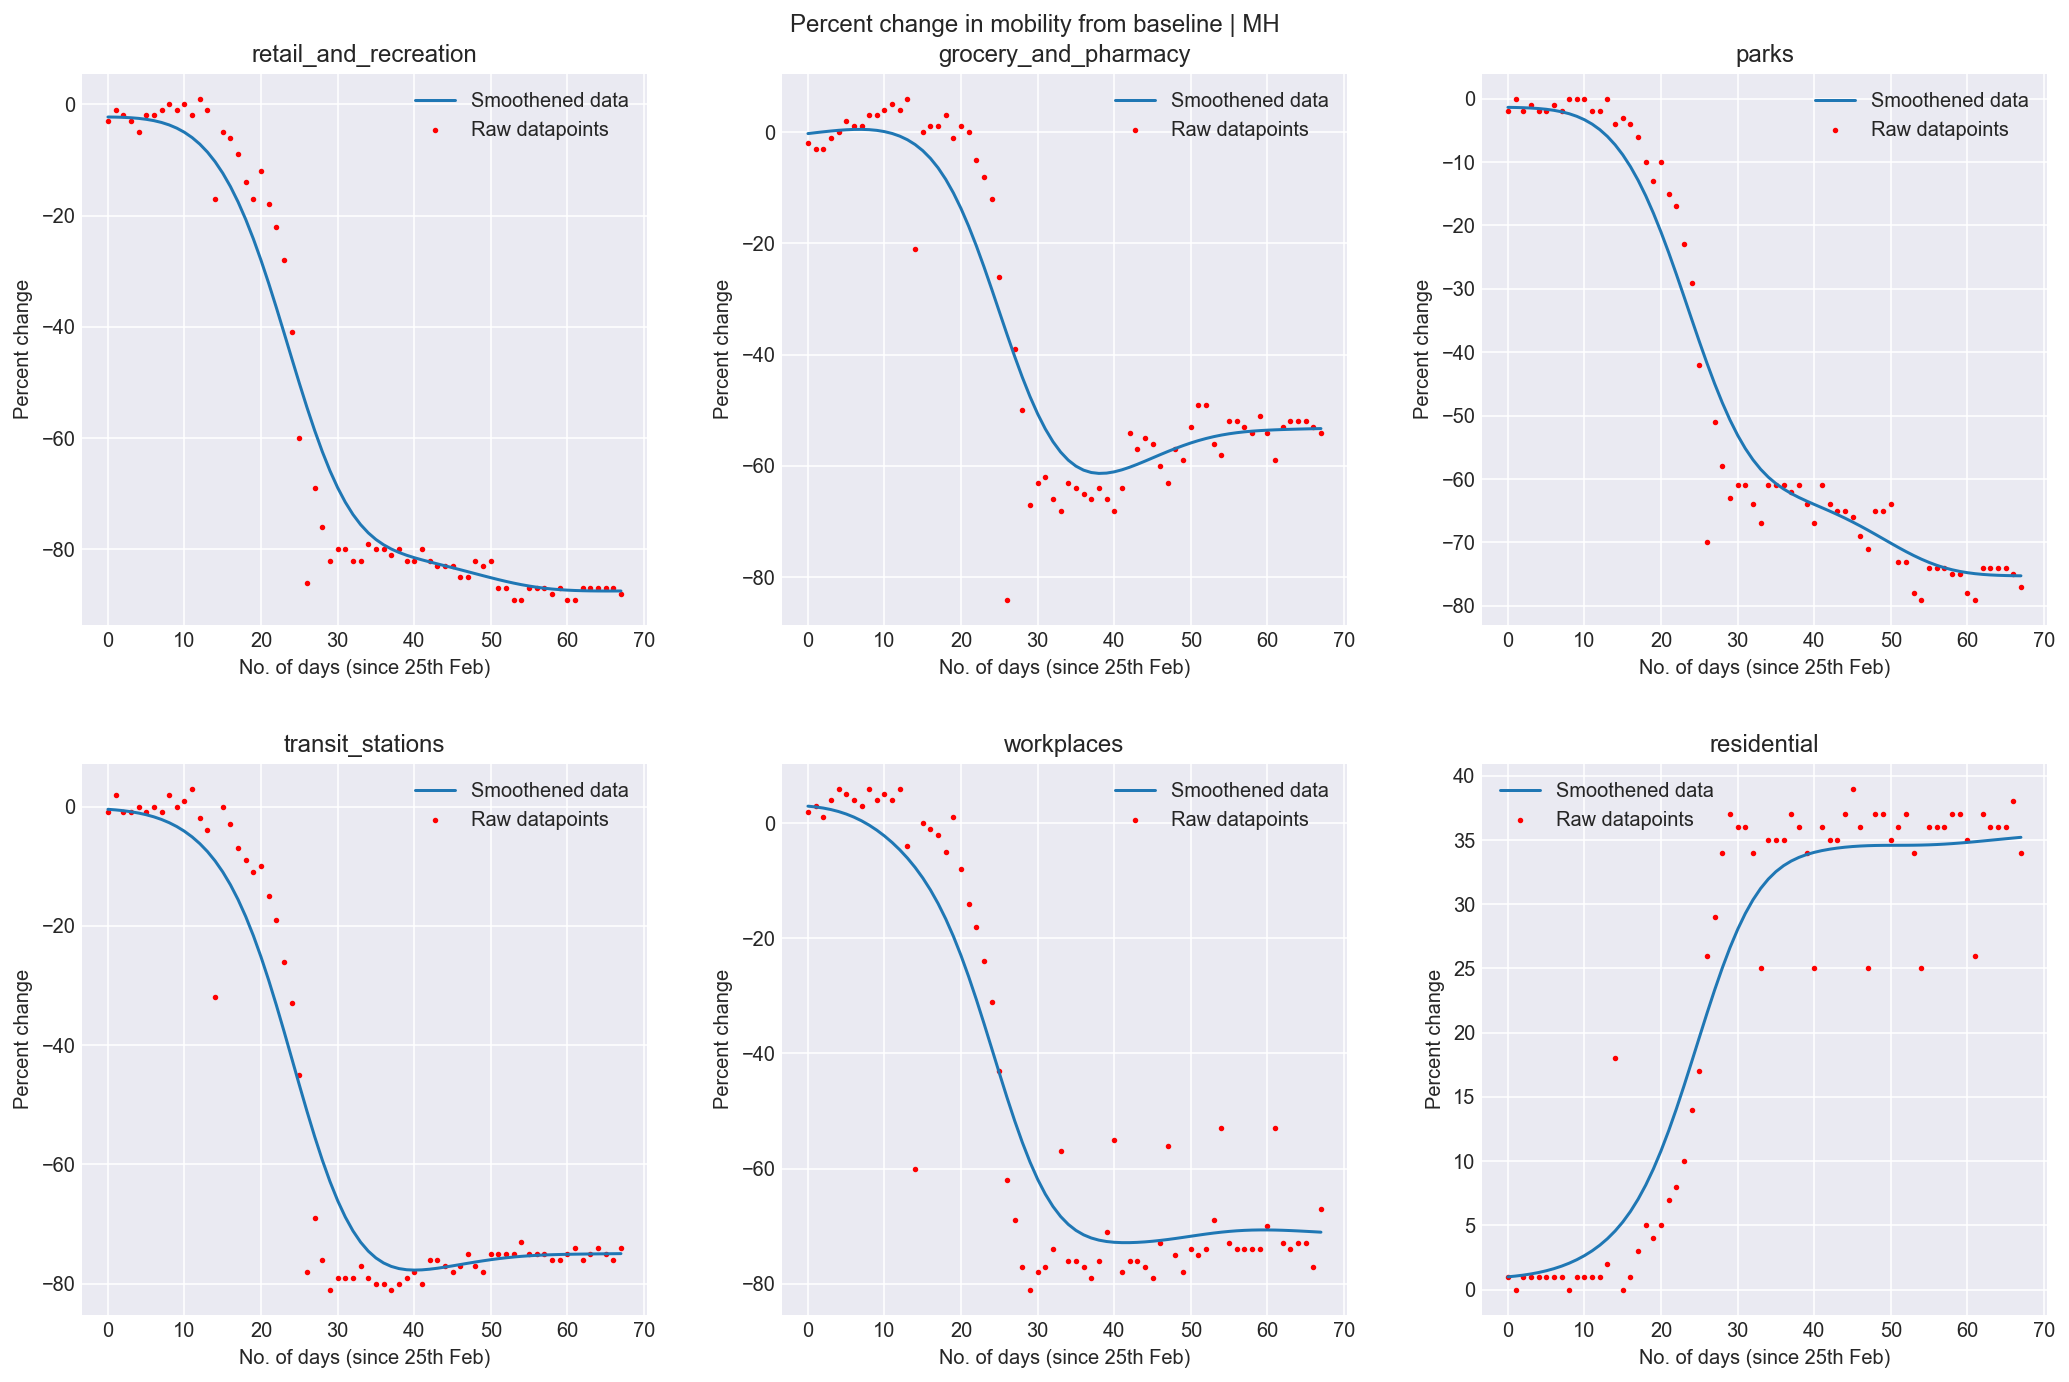

In [37]:
# Plot the data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
offset = 40

locations = ['retail_and_recreation',
             'grocery_and_pharmacy',
             'parks',
             'transit_stations',
             'workplaces',
             'residential']

for loc, ax in zip(locations, axs.flat):
    ydata = np.array(df['{}_percent_change_from_baseline'.format(loc)])
    xdata = range(len(ydata))
    ax.plot(xdata, smoothen(ydata, 6), label="Smoothened data")
    ax.scatter(xdata, ydata, label="Raw datapoints", s=3, c='red')
    ax.set_title("{}".format(loc))
    ax.set_xlabel("No. of days (since 25th Feb)")
    ax.set_ylabel("Percent change")
    ax.legend()
    
fig.suptitle("Percent change in mobility from baseline | MH")
fig.tight_layout(pad=3.0)

In [38]:
# Get the data
fetcher = DataFetcherState()
fetcher.fetch()

# Exclude these days many days from the starting of the cases time series
death_data = np.array(fetcher.data['mh']['deceased'], dtype=float)

social_distance = get_social_distance(df, death_data)

x0: [-3.4e+00 1.4e-03 1.0e+02 1.1e-02 1.3e+01 1.2e-02] conv: 2.332e+00112
x0: [-3.8e+00 5.9e-04 1.5e+02 7.9e-02 1.3e+01 9.6e-03] conv: 1.020e+0022
x0: [-3.3e+00 1.8e-03 9.5e+01 -3.4e-02 1.3e+01 1.1e-02] conv: 1.044e+003
x0: [-3.8e+00 5.7e-04 1.5e+02 8.2e-02 1.3e+01 9.6e-03] conv: 1.062e+0022
x0: [-3.3e+00 1.9e-03 9.5e+01 -4.0e-02 1.3e+01 1.1e-02] conv: 1.024e+00
x0: [-3.8e+00 4.7e-04 1.5e+02 1.0e-01 1.3e+01 1.0e-02] conv: 1.016e+002
x0: [-3.5e+00 1.0e-03 1.2e+02 5.6e-02 1.3e+01 1.2e-02] conv: 1.026e+002
x0: [-3.8e+00 2.1e-04 1.5e+02 1.4e-01 1.3e+01 1.1e-02] conv: 1.001e+0022
x0: [-3.6e+00 -7.6e-05 1.2e+02 1.7e-01 1.3e+01 1.6e-02] conv: 1.120e+002
x0: [-3.9e+00 1.3e-04 1.5e+02 1.7e-01 1.1e+01 9.4e-03] conv: 1.061e+002
x0: [-3.8e+00 -4.4e-04 1.5e+02 2.6e-01 1.3e+01 1.7e-02] conv: 1.003e+00
x0: [-4.0e+00 5.0e-04 1.4e+02 1.7e-01 8.8e+00 4.3e-03] conv: 1.044e+0032


,attention,days,alpha,beta,gamma,a,c_a,b,c_b,phi,c_phi
0,10,0,0.022094,100.100990,9209.458700,-3.368427,0.001360,103.651444,0.010872,12.995502,0.011843
0,20,0,0.018312,123.545851,19290.359833,-3.809118,0.000585,149.429055,0.079257,12.999572,0.009591
0,10,3,0.021096,105.810302,11245.524096,-3.255238,0.001846,94.631361,-0.034197,12.996103,0.011222
0,20,3,0.018311,123.239844,18926.863266,-3.812638,0.000574,149.899559,0.081553,12.997516,0.009633
0,10,7,0.020787,107.644246,11956.392022,-3.254762,0.001892,94.536306,-0.040077,12.999852,0.011040
0,20,7,0.018896,117.225943,15095.918872,-3.815151,0.000470,149.988084,0.100168,12.966201,0.010224
0,10,14,0.022255,97.087499,7893.351614,-3.481919,0.000998,115.156890,0.055765,12.998881,0.012422
0,20,14,0.020098,103.262491,8292.814276,-3.839648,0.000208,149.991340,0.144213,12.526114,0.010811
0,10,21,0.028585,68.921393,2386.327154,-3.579285,-0.000076,122.829494,0.166663,12.998422,0.016141
0,20,21,0.019428,94.627577,4459.539391,-3.899397,0.000129,149.960468,0.171068,11.452760,0.009429


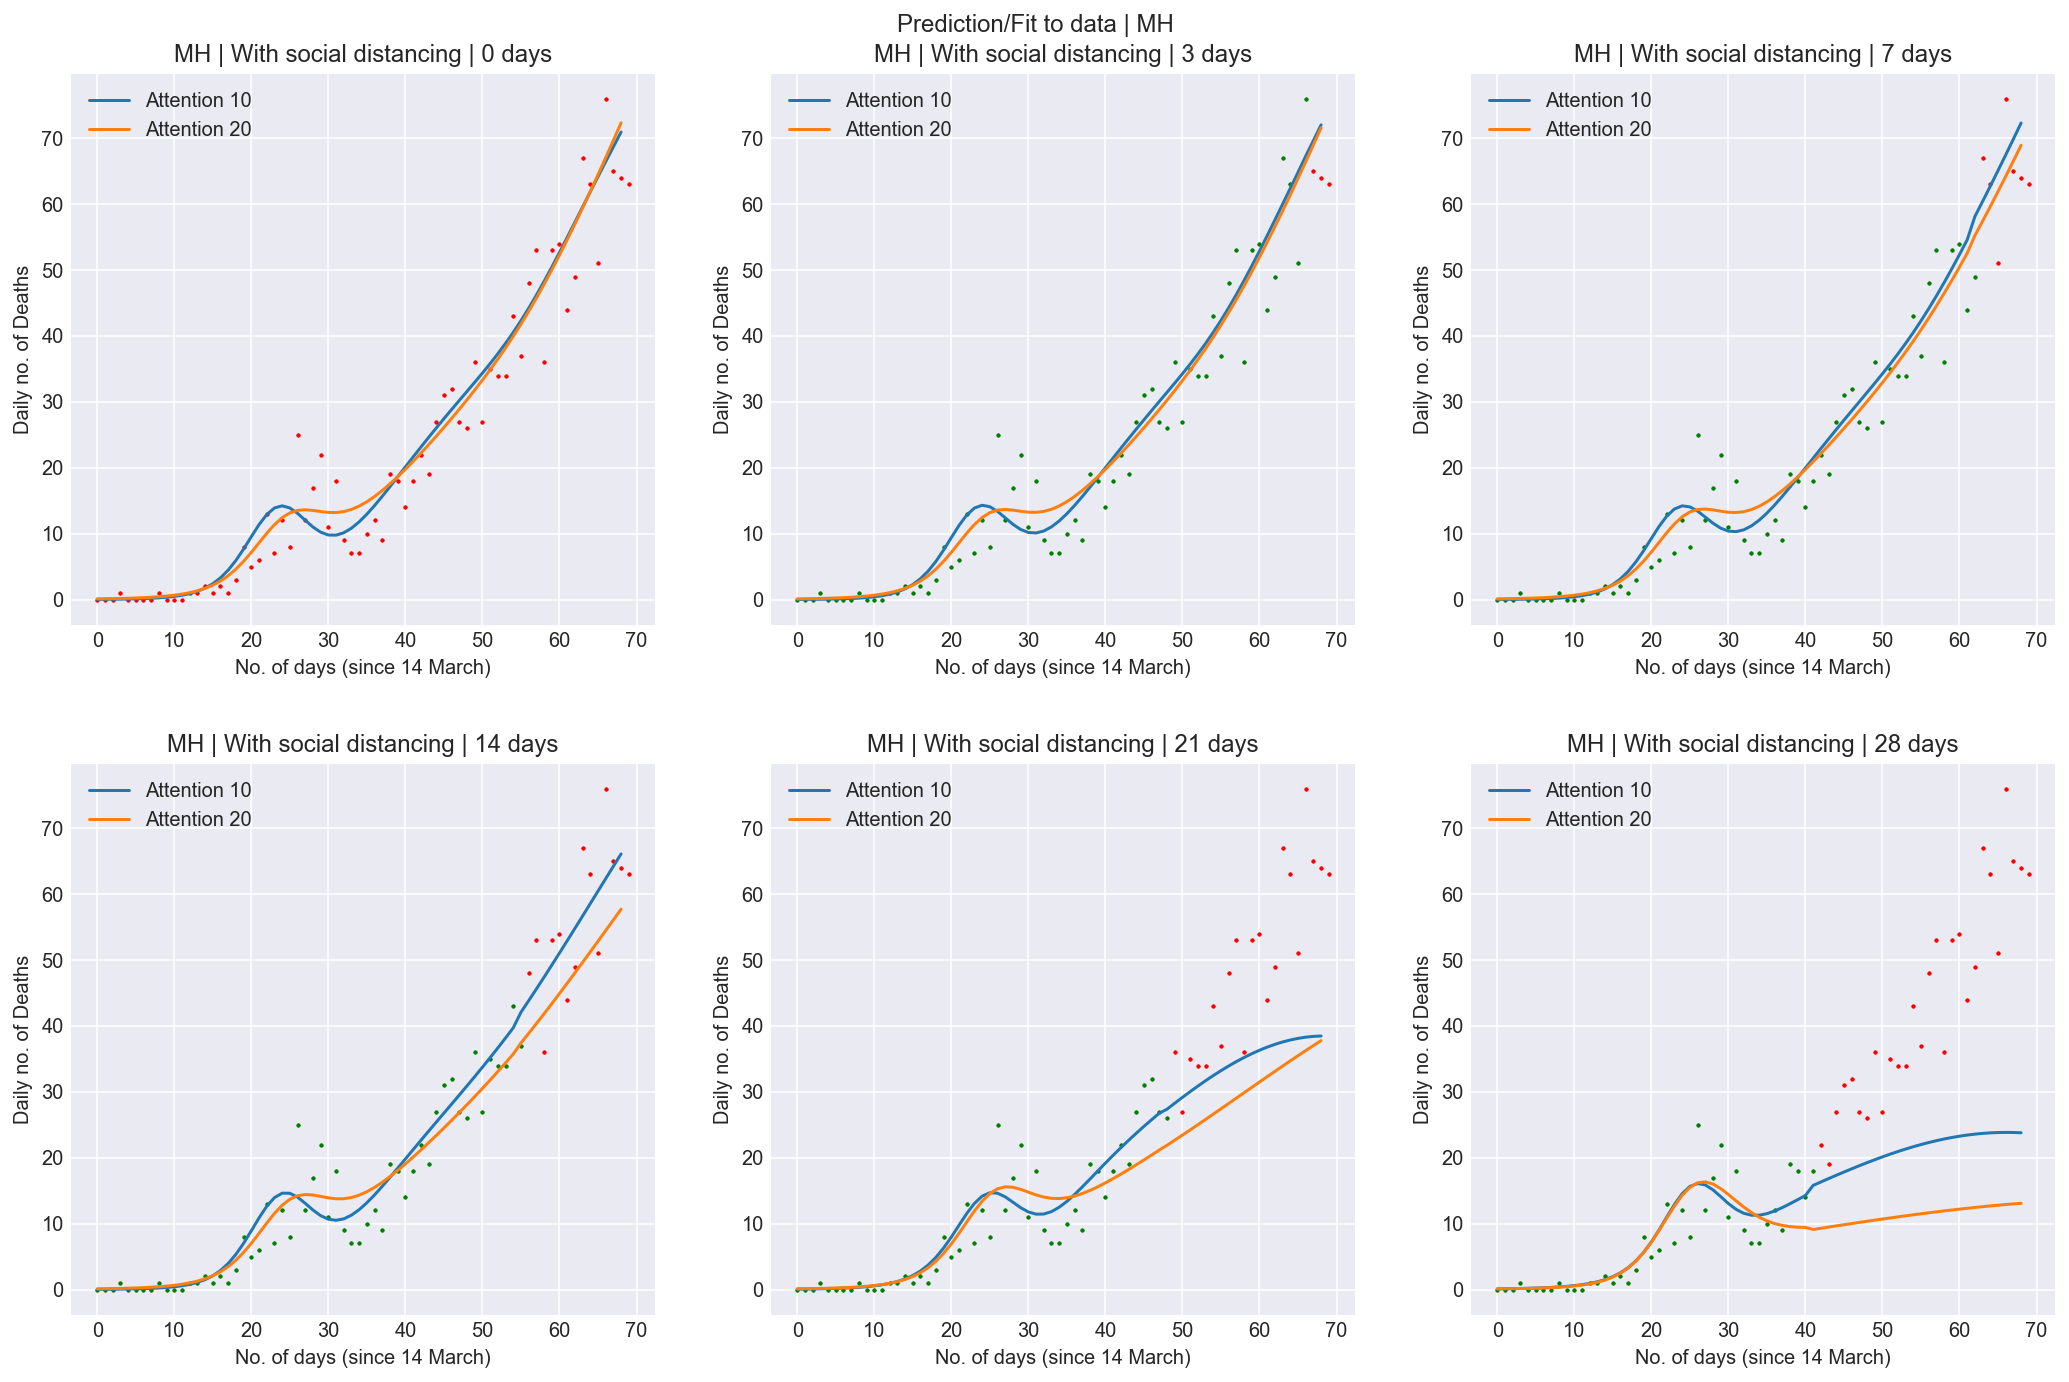

In [39]:
# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
param_table = pd.DataFrame()
future_days = [0, 3, 7, 14, 21, 28]

for fut, ax in zip(future_days, axs.flat):
    s_death_data = death_data[:-fut] if fut != 0 else death_data
    social_distance = get_social_distance(df, s_death_data)
    
    for attention in [10, 20]:
        # Fit and plot data
        np.random.seed(seed=123)

        warnings.filterwarnings("ignore")
        model_india = GaussianCDF(social_distance, loss_fun=partial(attentive_loss, attention=attention))
        model_india.fit(s_death_data, fe_init=[-3, 0.00, 100, 0, 10.0, 0], verbose=True)
        warnings.filterwarnings("default")
        print("")

        params = model_india.get_params()
        new_row = pd.DataFrame({
            "attention": attention,
            "days"     : [fut],
            "alpha"    : [params[0]],
            "beta"     : [params[1]],
            "gamma"    : [params[2]],
            "a"        : [model_india.model.result.x[0]],
            "c_a"      : [model_india.model.result.x[1]],
            "b"        : [model_india.model.result.x[2]],
            "c_b"      : [model_india.model.result.x[3]],
            "phi"      : [model_india.model.result.x[4]],
            "c_phi"    : [model_india.model.result.x[5]]
        })
        param_table = param_table.append(new_row)

        time_values = np.arange(social_distance.shape[0] + fut)
        pred = model_india.predict_covar(time_values)

        ax.plot(time_values[:-1], np.diff(np.exp(pred)), label="Attention {}".format(attention))
        ax.scatter(time_values[:-fut], death_data[:-fut], c='green', s=1)
        ax.scatter(time_values[-fut:], death_data[-fut:], c='red', s=1)
        
    ax.set_title("MH | With social distancing | {} days".format(fut))
    ax.set_xlabel("No. of days (since 14 March)")
    ax.set_ylabel("Daily no. of Deaths")
    ax.legend()

display(param_table)
    
fig.suptitle("Prediction/Fit to data | MH")
fig.tight_layout(pad=3.0)

<h3>Delhi</h3>

In [40]:
# Get dataframe for the entire country from 25th Feb
# Although the death data starts from 14 March, we use mobilities from 25th Feb
# This is because the mean time to death is 18 days and so we shift the mobility data by 18 days forward
df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df = df[df['country_region'] == 'India']
df = df[df['sub_region_1'] == 'Delhi']
df = df[df['date'] >= '2020-02-25']

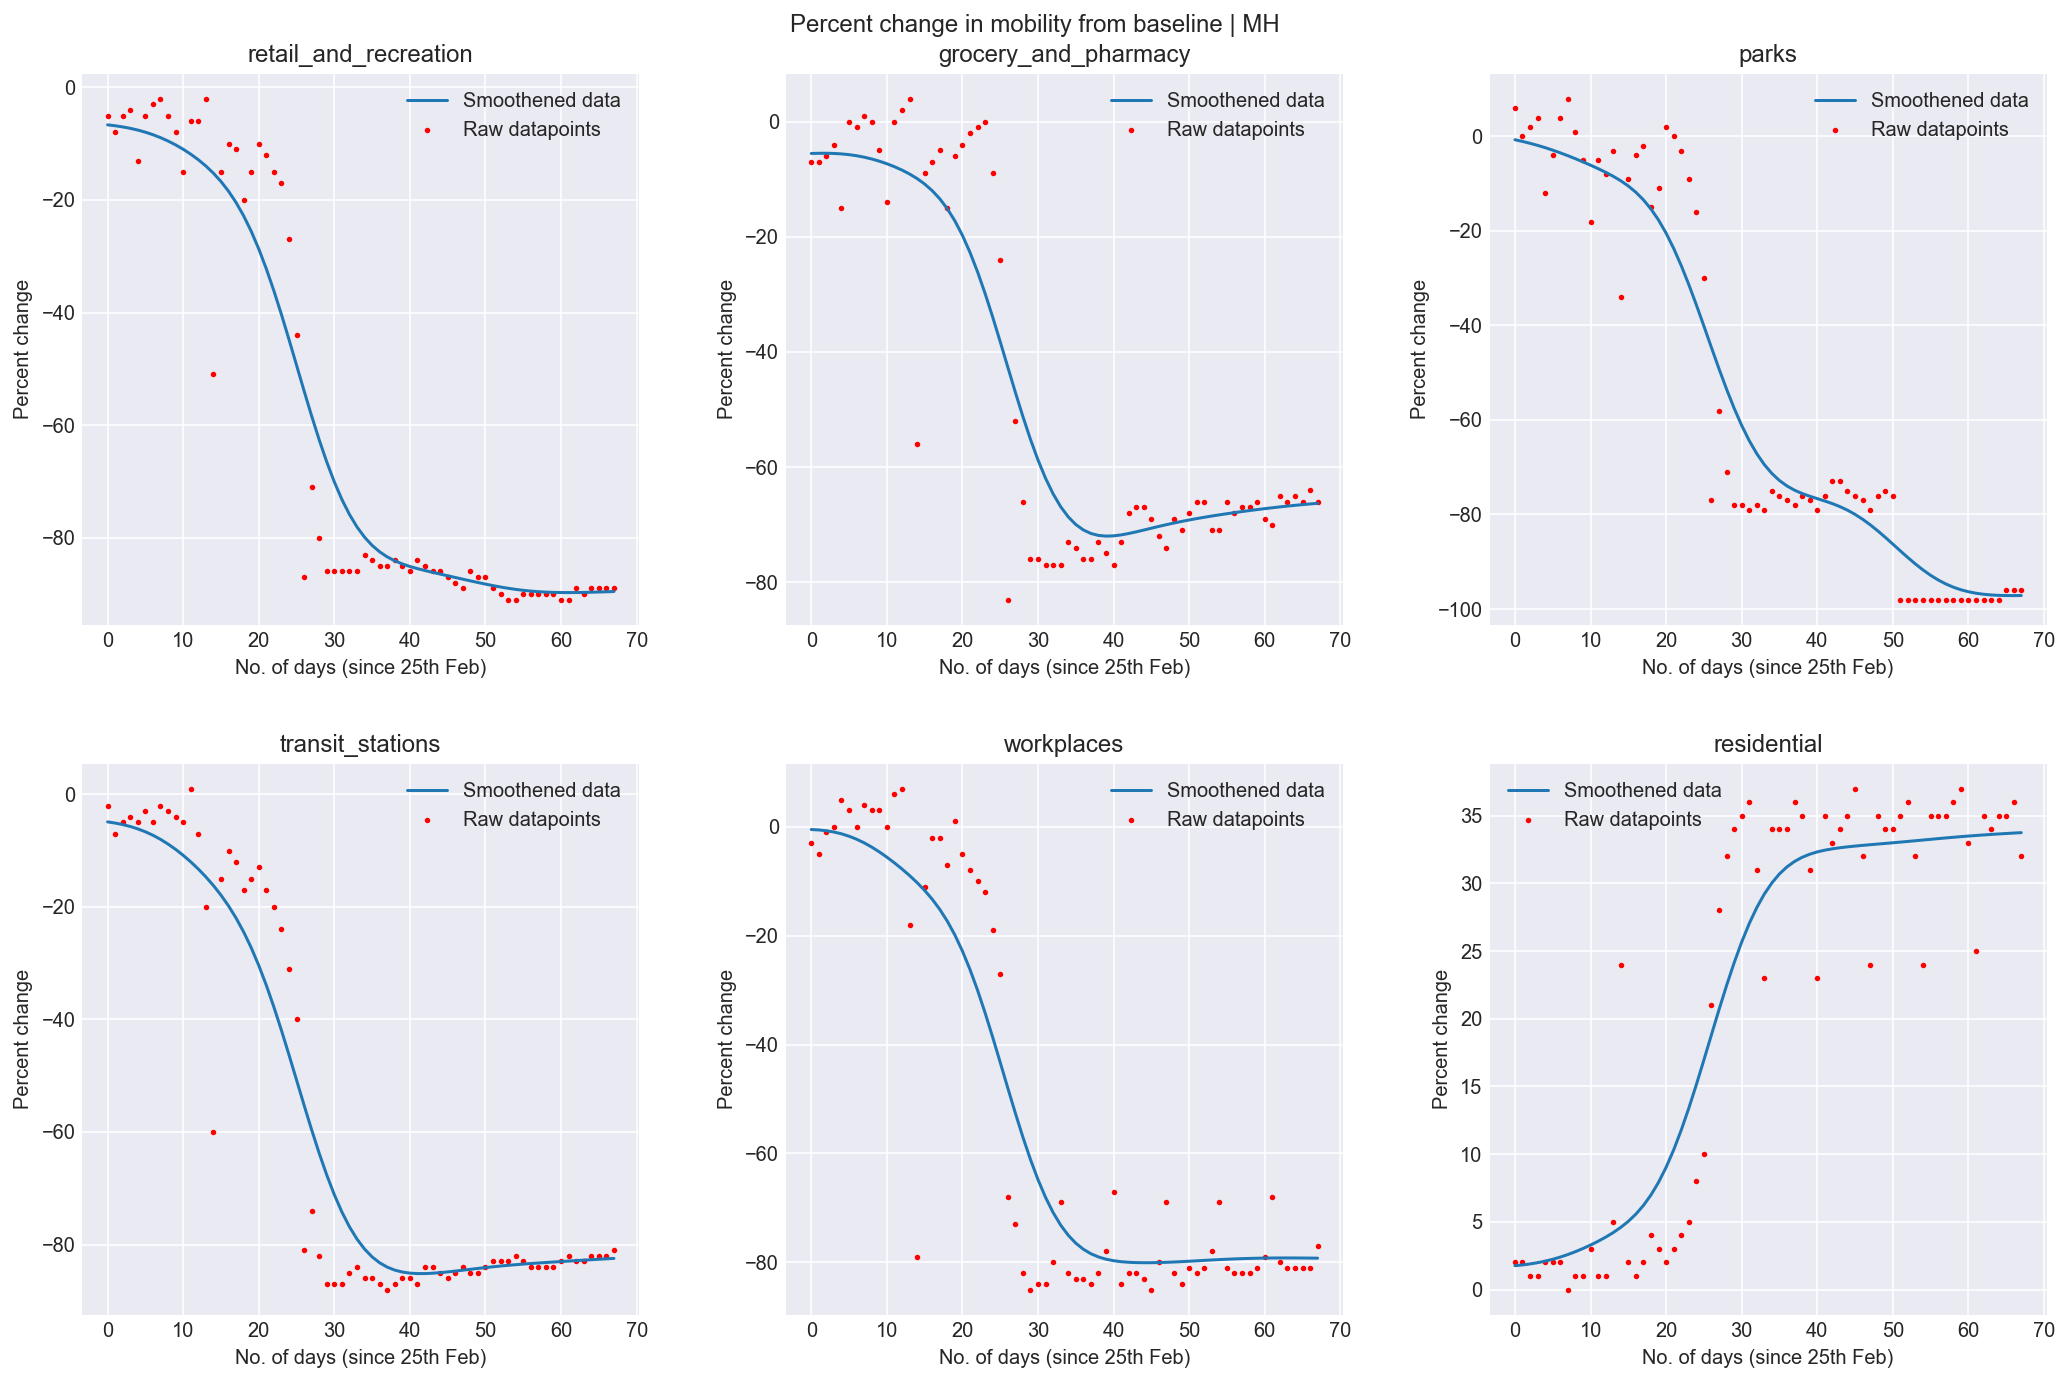

In [41]:
# Plot the data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

locations = ['retail_and_recreation',
             'grocery_and_pharmacy',
             'parks',
             'transit_stations',
             'workplaces',
             'residential']

for loc, ax in zip(locations, axs.flat):
    ydata = np.array(df['{}_percent_change_from_baseline'.format(loc)])
    xdata = range(len(ydata))
    ax.plot(xdata, smoothen(ydata, 6), label="Smoothened data")
    ax.scatter(xdata, ydata, label="Raw datapoints", s=3, c='red')
    ax.set_title("{}".format(loc))
    ax.set_xlabel("No. of days (since 25th Feb)")
    ax.set_ylabel("Percent change")
    ax.legend()
    
fig.suptitle("Percent change in mobility from baseline | MH")
fig.tight_layout(pad=3.0)

In [29]:
# Get the data
fetcher = DataFetcherState()
fetcher.fetch()

# Exclude these days many days from the starting of the cases time series
death_data = np.array(fetcher.data['dl']['deceased'], dtype=float)

social_distance = get_social_distance(df, death_data)

x0: [-3.8e+00 1.3e-04 9.8e+01 -3.0e-03 9.6e+00 1.2e-03] conv: 1.008e+003
x0: [-3.7e+00 6.6e-04 1.4e+02 5.2e-02 1.3e+01 8.9e-03] conv: 1.001e+002
x0: [-3.7e+00 3.4e-04 1.1e+02 3.2e-02 1.1e+01 5.6e-03] conv: 1.054e+0022
x0: [-3.7e+00 6.6e-04 1.4e+02 5.1e-02 1.3e+01 8.7e-03] conv: 1.142e+0022
x0: [-3.4e+00 1.1e-03 1.1e+02 -1.2e-02 1.3e+01 8.9e-03] conv: 1.069e+00
x0: [-3.7e+00 6.0e-04 1.4e+02 6.2e-02 1.3e+01 8.8e-03] conv: 1.240e+0022
x0: [-3.3e+00 1.3e-03 9.8e+01 -4.0e-03 1.3e+01 1.0e-02] conv: 1.120e+00
x0: [-3.8e+00 3.6e-04 1.5e+02 1.1e-01 1.3e+01 1.0e-02] conv: 1.063e+0023
x0: [-3.5e+00 1.6e-04 1.2e+02 1.3e-01 1.3e+01 1.4e-02] conv: 1.027e+002
x0: [-3.8e+00 2.2e-04 1.5e+02 1.5e-01 1.2e+01 9.8e-03] conv: 1.032e+0022
x0: [-3.8e+00 3.5e-05 1.5e+02 1.9e-01 1.3e+01 1.4e-02] conv: 1.023e+002
x0: [-4.0e+00 6.8e-04 1.5e+02 1.7e-01 9.3e+00 5.2e-03] conv: 1.001e+002


,attention,days,alpha,beta,gamma,a,c_a,b,c_b,phi,c_phi
0,10,0,0.022110,99.344647,8889.250305,-3.761569,0.000132,98.207526,-0.002996,9.562866,0.001239
0,20,0,0.019470,115.429780,15233.561279,-3.689595,0.000657,135.180590,0.052032,12.997980,0.008869
0,10,3,0.021922,101.242686,9638.717335,-3.688657,0.000345,113.301304,0.031589,11.310234,0.005597
0,20,3,0.019119,117.547350,16020.918953,-3.703730,0.000664,136.898874,0.050694,12.998216,0.008688
0,10,7,0.020647,111.753692,14759.029472,-3.440528,0.001147,106.999297,-0.012401,12.999445,0.008868
0,20,7,0.019011,116.800708,14899.800362,-3.733687,0.000597,140.683884,0.062297,12.999217,0.008843
0,10,14,0.022311,99.814731,9218.969219,-3.295824,0.001346,98.299600,-0.004023,12.999526,0.010276
0,20,14,0.019512,107.853845,9647.076191,-3.801851,0.000358,149.977467,0.111834,12.999486,0.010155
0,10,21,0.027645,72.714637,2858.784416,-3.530649,0.000158,118.981686,0.126382,12.997727,0.013766
0,20,21,0.019603,95.272407,4712.968769,-3.849941,0.000224,149.977583,0.149432,12.040300,0.009785


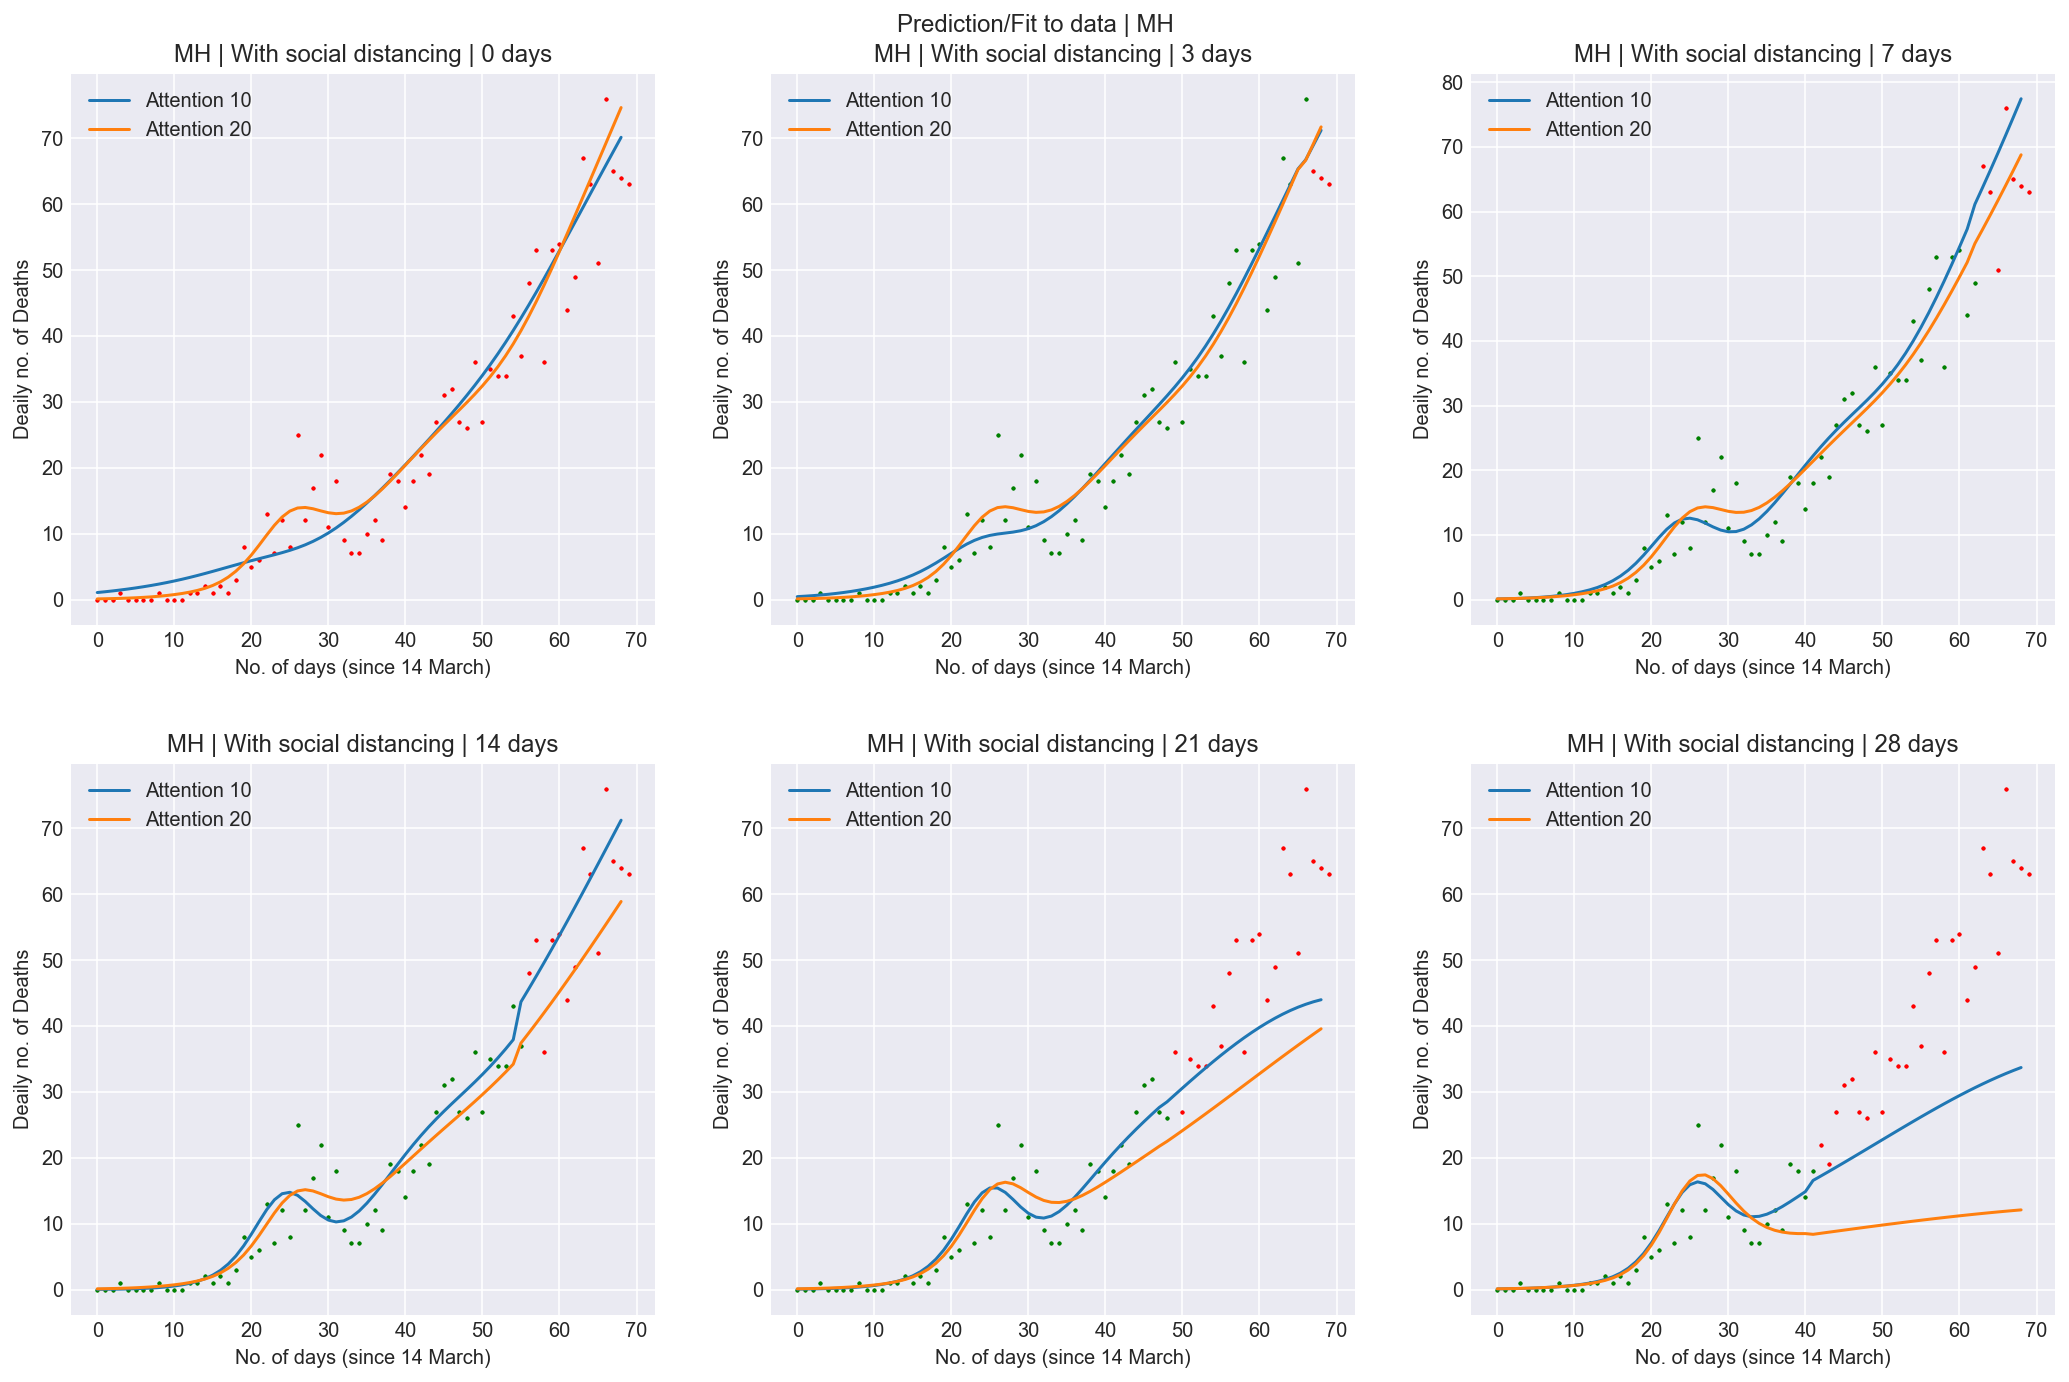

In [42]:
# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
param_table = pd.DataFrame()
future_days = [0, 3, 7, 14, 21, 28]

for fut, ax in zip(future_days, axs.flat):
    s_death_data = death_data[:-fut] if fut != 0 else death_data
    social_distance = get_social_distance(df, s_death_data)
    
    for attention in [10, 20]:
        # Fit and plot data
        np.random.seed(seed=123)

        warnings.filterwarnings("ignore")
        model_india = GaussianCDF(social_distance, loss_fun=partial(attentive_loss, attention=attention))
        model_india.fit(s_death_data, fe_init=[-3, 0.00, 100, 0, 10.0, 0], verbose=True)
        warnings.filterwarnings("default")
        print("")

        params = model_india.get_params()
        new_row = pd.DataFrame({
            "attention": attention,
            "days"     : [fut],
            "alpha"    : [params[0]],
            "beta"     : [params[1]],
            "gamma"    : [params[2]],
            "a"        : [model_india.model.result.x[0]],
            "c_a"      : [model_india.model.result.x[1]],
            "b"        : [model_india.model.result.x[2]],
            "c_b"      : [model_india.model.result.x[3]],
            "phi"      : [model_india.model.result.x[4]],
            "c_phi"    : [model_india.model.result.x[5]]
        })
        param_table = param_table.append(new_row)

        time_values = np.arange(social_distance.shape[0] + fut)
        pred = model_india.predict_covar(time_values)

        ax.plot(time_values[:-1], np.diff(np.exp(pred)), label="Attention {}".format(attention))
        ax.scatter(time_values[:-fut], death_data[:-fut], c='green', s=1)
        ax.scatter(time_values[-fut:], death_data[-fut:], c='red', s=1)
        
    ax.set_title("MH | With social distancing | {} days".format(fut))
    ax.set_xlabel("No. of days (since 14 March)")
    ax.set_ylabel("Deaily no. of Deaths")
    ax.legend()

display(param_table)
    
fig.suptitle("Prediction/Fit to data | MH")
fig.tight_layout(pad=3.0)

<h3>Gujarat</h3>

In [43]:
# Get dataframe for the entire country from 25th Feb
# Although the death data starts from 14 March, we use mobilities from 25th Feb
# This is because the mean time to death is 18 days and so we shift the mobility data by 18 days forward
df = pd.read_csv("Global_Mobility_Report.csv", low_memory=False)
df = df[df['country_region'] == 'India']
df = df[df['sub_region_1'] == 'Gujarat']
df = df[df['date'] >= '2020-02-25']

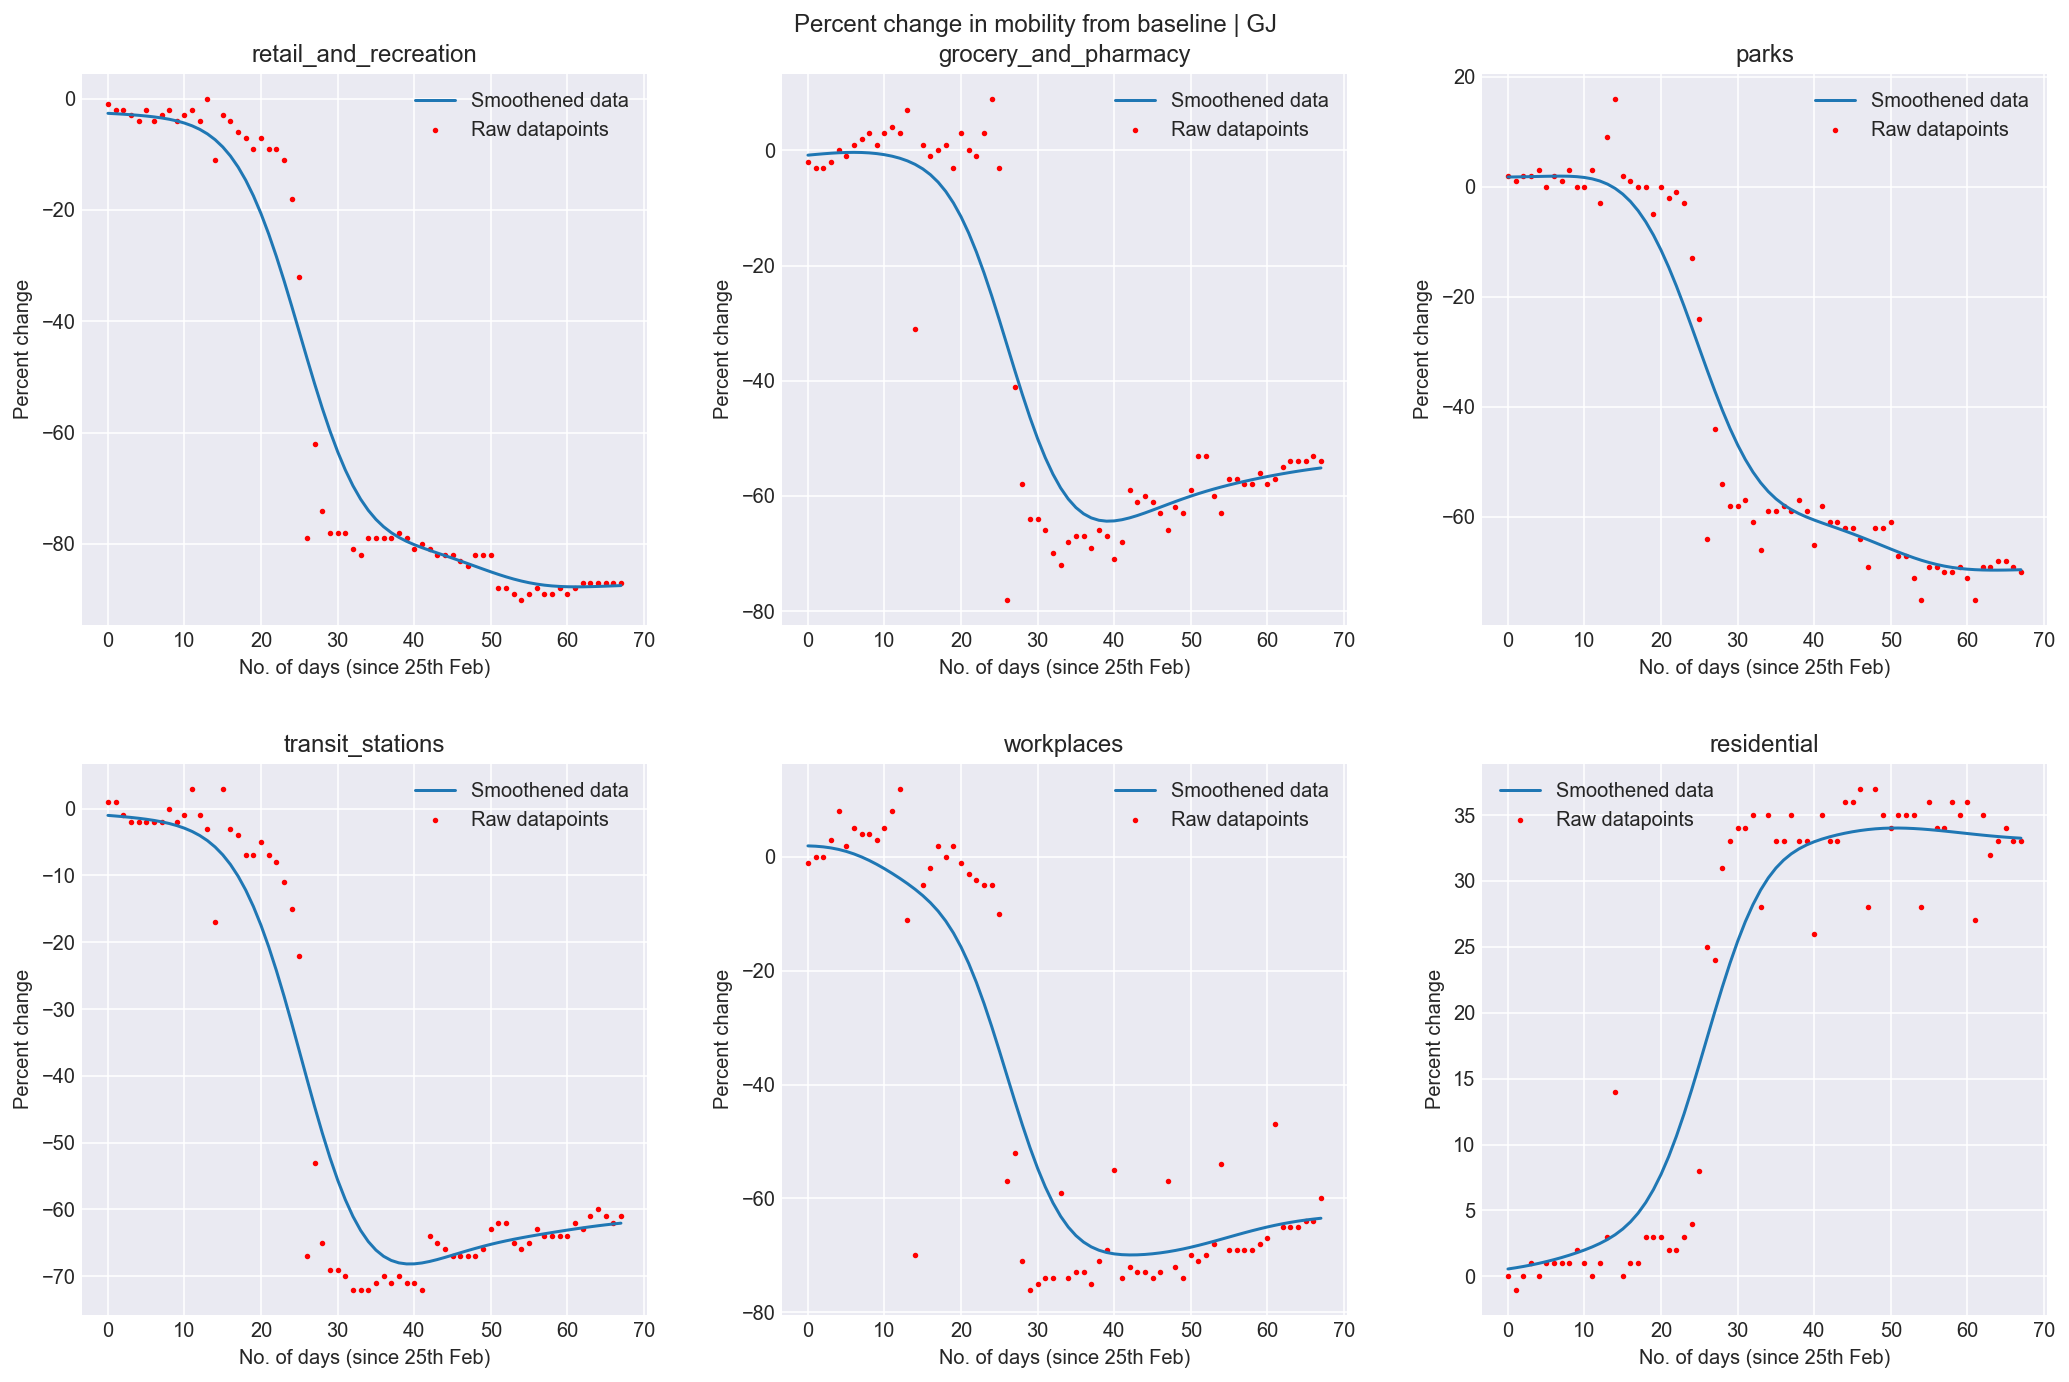

In [44]:
# Plot the data
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

locations = ['retail_and_recreation',
             'grocery_and_pharmacy',
             'parks',
             'transit_stations',
             'workplaces',
             'residential']

for loc, ax in zip(locations, axs.flat):
    ydata = np.array(df['{}_percent_change_from_baseline'.format(loc)])
    xdata = range(len(ydata))
    ax.plot(xdata, smoothen(ydata, 6), label="Smoothened data")
    ax.scatter(xdata, ydata, label="Raw datapoints", s=3, c='red')
    ax.set_title("{}".format(loc))
    ax.set_xlabel("No. of days (since 25th Feb)")
    ax.set_ylabel("Percent change")
    ax.legend()
    
fig.suptitle("Percent change in mobility from baseline | GJ")
fig.tight_layout(pad=3.0)

In [45]:
# Get the data
fetcher = DataFetcherState()
fetcher.fetch()

# Exclude these days many days from the starting of the cases time series
death_data = np.array(fetcher.data['gj']['deceased'], dtype=float)

social_distance = get_social_distance(df, death_data)

x0: [-3.4e+00 -1.1e-03 7.3e+01 4.9e-02 8.0e+00 3.4e-03] conv: 1.004e+002
x0: [-3.4e+00 -1.1e-03 7.6e+01 5.4e-02 8.0e+00 3.2e-03] conv: 1.081e+00
x0: [-3.4e+00 -1.1e-03 7.4e+01 4.9e-02 8.0e+00 3.3e-03] conv: 1.174e+002
x0: [-3.4e+00 -1.1e-03 7.7e+01 5.2e-02 8.0e+00 2.9e-03] conv: 1.034e+002
x0: [-3.4e+00 -1.0e-03 7.6e+01 4.8e-02 8.0e+00 2.9e-03] conv: 1.092e+0022
x0: [-3.5e+00 -9.5e-04 8.0e+01 4.8e-02 8.0e+00 2.2e-03] conv: 1.035e+003
x0: [-3.5e+00 -6.6e-04 8.3e+01 2.5e-02 8.0e+00 -9.6e-05] conv: 1.004e+002
x0: [-3.7e+00 3.6e-04 1.2e+02 -1.1e-01 1.0e+01 -8.1e-03] conv: 1.135e+003
x0: [-3.6e+00 -4.1e-04 1.1e+02 1.7e-02 9.7e+00 -8.5e-04] conv: 1.038e+001
x0: [-3.8e+00 -2.5e-04 1.5e+02 1.5e-02 1.2e+01 -9.8e-04] conv: 1.005e+001
x0: [-3.8e+00 -7.7e-04 1.4e+02 -4.0e-02 1.2e+01 -1.8e-02] conv: 1.078e+00
x0: [-3.9e+00 -8.4e-04 1.5e+02 -3.6e-02 1.2e+01 -2.0e-02] conv: 1.087e+00


,attention,days,alpha,beta,gamma,a,c_a,b,c_b,phi,c_phi
0,30,0,0.048528,58.560753,1.056601e+03,-3.363663,-0.001118,73.493266,0.049366,8.003386,0.003440
0,40,0,0.046446,60.011246,1.134816e+03,-3.407091,-0.001116,76.299582,0.053848,8.002431,0.003201
0,30,3,0.048010,58.968148,1.080982e+03,-3.372466,-0.001099,74.080640,0.049431,8.002397,0.003326
0,40,3,0.045136,61.337571,1.228402e+03,-3.421136,-0.001057,77.277533,0.052137,8.000649,0.002902
0,30,7,0.045988,61.013683,1.235151e+03,-3.397169,-0.001024,75.797400,0.047633,8.009409,0.002869
0,40,7,0.042448,64.726647,1.532176e+03,-3.453616,-0.000948,79.650651,0.048085,8.004768,0.002160
0,30,14,0.037418,74.995796,3.218035e+03,-3.492475,-0.000665,82.889190,0.025367,8.042449,-0.000110
0,40,14,0.021794,151.923238,3.551419e+05,-3.714993,0.000357,118.830223,-0.106350,10.274071,-0.008054
0,30,21,0.029903,101.570302,2.212353e+04,-3.635916,-0.000405,106.794821,0.016790,9.741072,-0.000846
0,40,21,0.023767,142.274739,3.448526e+05,-3.817099,-0.000249,147.003304,0.015197,12.446792,-0.000977


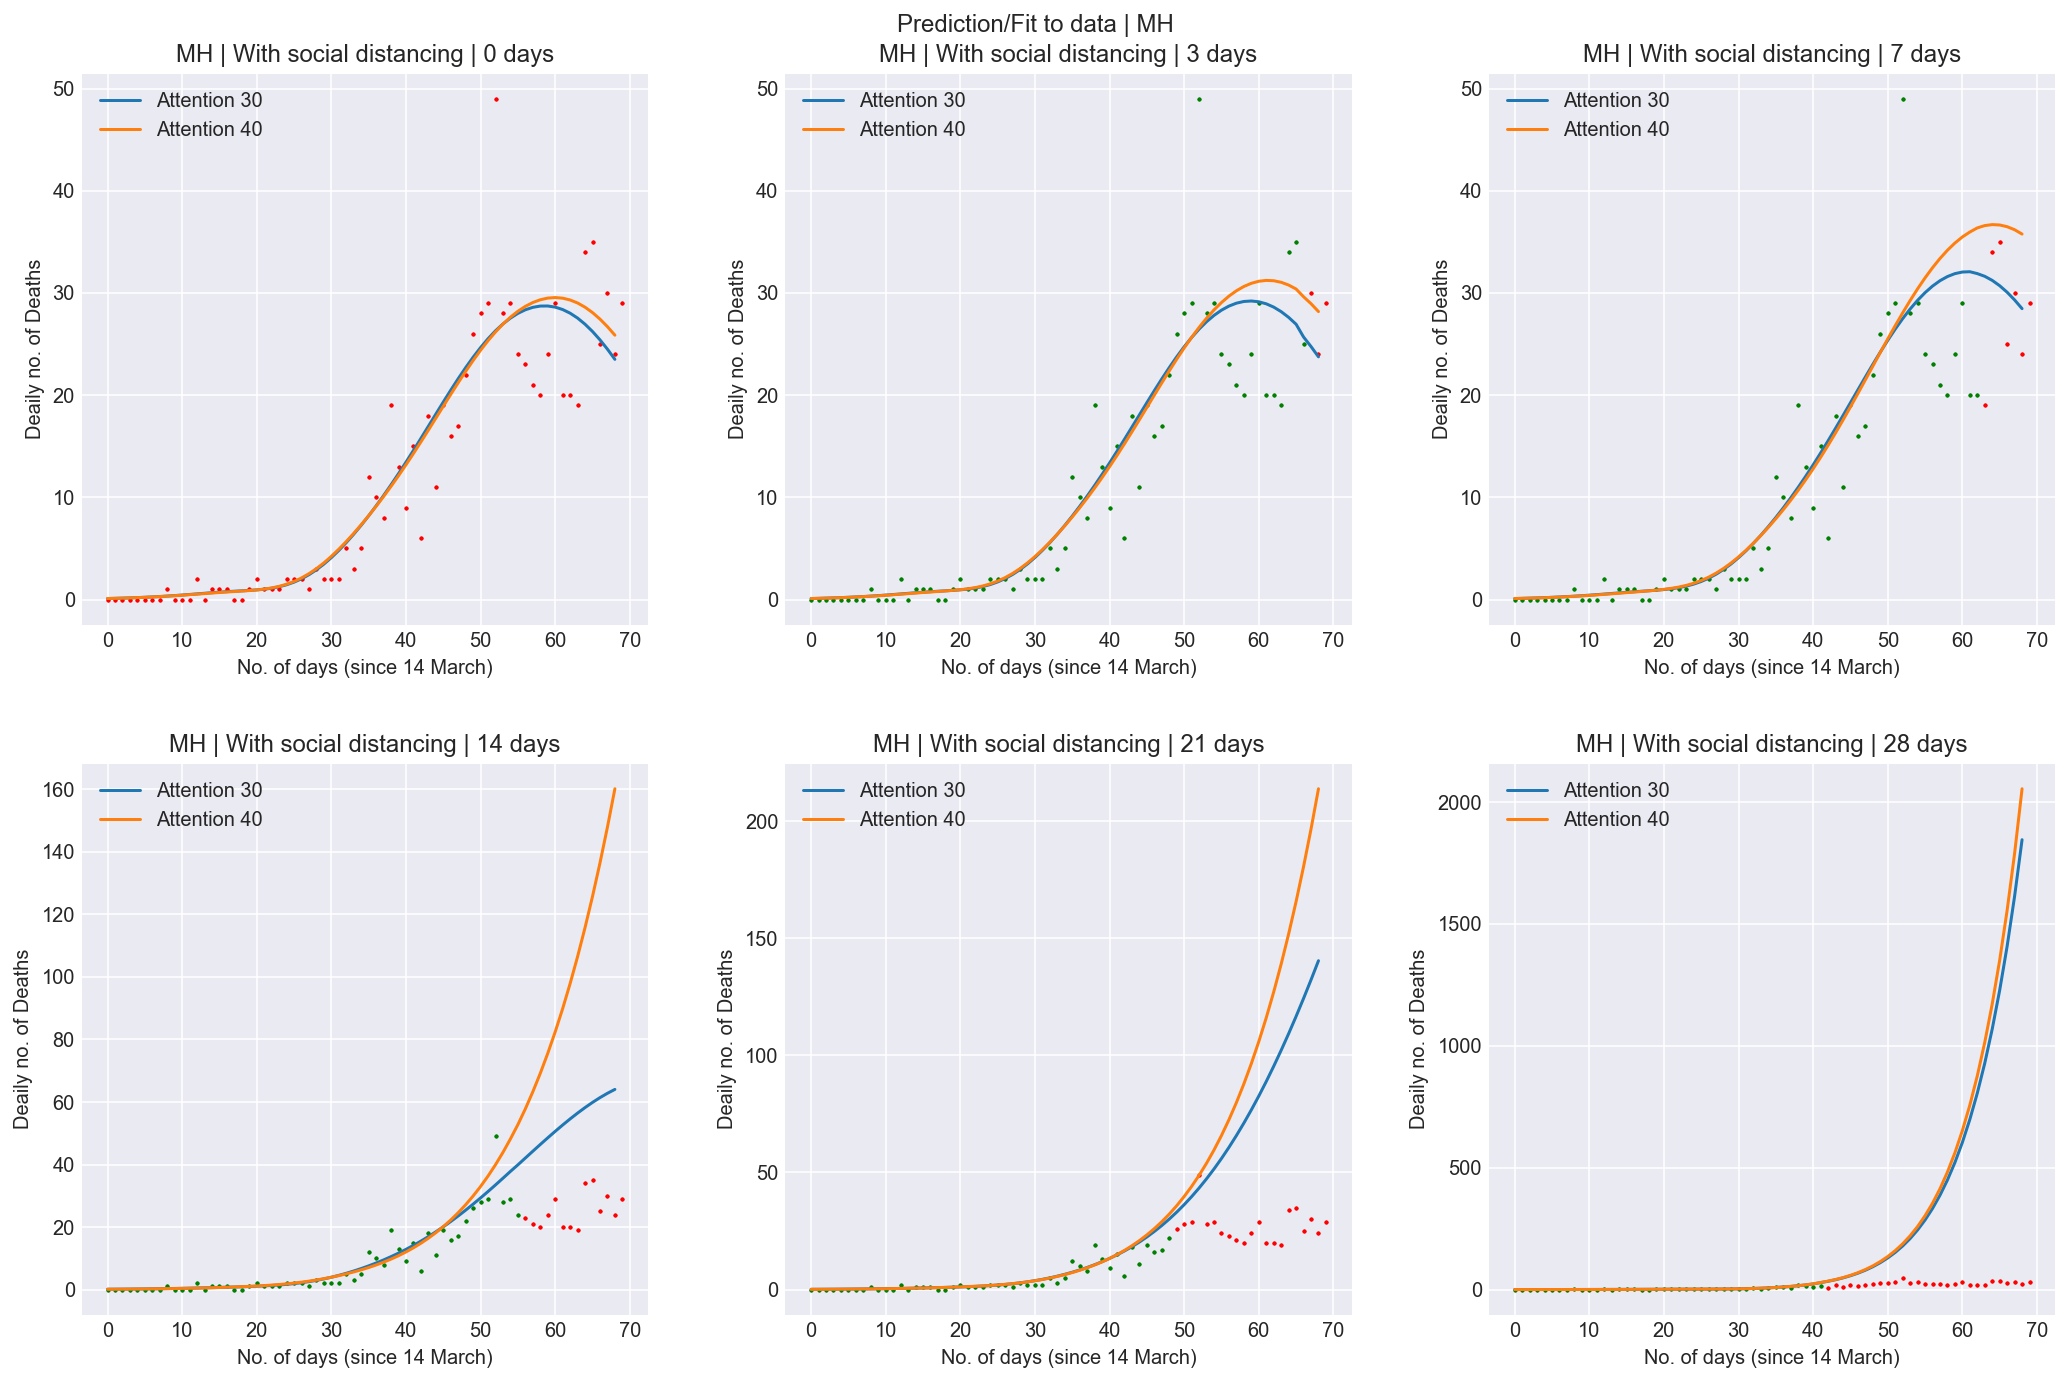

In [47]:
# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
param_table = pd.DataFrame()
future_days = [0, 3, 7, 14, 21, 28]

for fut, ax in zip(future_days, axs.flat):
    s_death_data = death_data[:-fut] if fut != 0 else death_data
    social_distance = get_social_distance(df, s_death_data)
    
    for attention in [30, 40]:
        # Fit and plot data
        np.random.seed(seed=123)

        warnings.filterwarnings("ignore")
        model_india = GaussianCDF(social_distance, loss_fun=partial(attentive_loss, attention=attention))
        model_india.fit(s_death_data, fe_init=[-3, 0.00, 100, 0, 10.0, 0], verbose=True)
        warnings.filterwarnings("default")
        print("")

        params = model_india.get_params()
        new_row = pd.DataFrame({
            "attention": attention,
            "days"     : [fut],
            "alpha"    : [params[0]],
            "beta"     : [params[1]],
            "gamma"    : [params[2]],
            "a"        : [model_india.model.result.x[0]],
            "c_a"      : [model_india.model.result.x[1]],
            "b"        : [model_india.model.result.x[2]],
            "c_b"      : [model_india.model.result.x[3]],
            "phi"      : [model_india.model.result.x[4]],
            "c_phi"    : [model_india.model.result.x[5]]
        })
        param_table = param_table.append(new_row)

        time_values = np.arange(social_distance.shape[0] + fut)
        pred = model_india.predict_covar(time_values)

        ax.plot(time_values[:-1], np.diff(np.exp(pred)), label="Attention {}".format(attention))
        ax.scatter(time_values[:-fut], death_data[:-fut], c='green', s=1)
        ax.scatter(time_values[-fut:], death_data[-fut:], c='red', s=1)
        
    ax.set_title("MH | With social distancing | {} days".format(fut))
    ax.set_xlabel("No. of days (since 14 March)")
    ax.set_ylabel("Deaily no. of Deaths")
    ax.legend()

display(param_table)
    
fig.suptitle("Prediction/Fit to data | MH")
fig.tight_layout(pad=3.0)